# TP FINAL GRUPO 4: “Pronóstico de llamadas para servicio telefonico en una empresa Fintech”

GIRASOLE, Giuliana

GONZÁLEZ, Yanina

HILAL, Agustina 

MARCONE, Fátima

MAURIZIO, Estefanía

Enlace a la presentación: https://view.genially.com/66454e61dba6cd0014bb4400/presentation-tp-final-g4

<h2 style="font-style: italic;">Contexto y objetivo del trabajo</h2>

Este trabajo tiene como objetivo generar y evaluar un modelo adecuado para predecir cuántas llamadas va a recibir el Contact Center de Clientes en una determinada franja horaria. Al conocer este valor, se podrá ofrecer una mejor atención al cliente que realiza una llamada y, a la vez, se contratará el servicio de callcenter de forma más eficiente, evitando gastos innecesarios.

En cuanto a la contratación del servicio, se necesita predecir la cantidad de llamadas un mes antes del pago. Por ejemplo, entre el 6 y 7 de enero se necesita el pronóstico de las llamadas que ingresarán al Contact Center en el mes de febrero. Esto se debe a que se contrata un proveedor externo, quien se encarga de gestionar el personal que atenderá dichas llamadas.

Tanto la captura de datos como la predicción se realiza para intervalos de 30 minutos y el negocio estudia un rango de atención de lunes a viernes desde las 8:30 a 20:30 h. Sin embargo, se debe tener en cuenta que no se usó la misma franja horaria en todos los años que de gestión, por lo cual, hay que considerar esto en la calidad de los datos que se usaron para el modelo actual. No obstante, esta franja es la que se utiliza actualmente y la que se debe mantener para calcular costos y calidad de servicio a futuro. 

Los pasos a seguir seran los siguientes:
1) Explorar, visualizar y analizar los datos y asegurar que la base este en condiciones para confeccionar el modelo 
2) Definir, entrenar y evaluar modelos alternativos con el objetivo de predecir el volumen de llamadas mensuales por dia y por intervalo

A partir del modelo seleccionado y las predicciones realizadas, la empresa luego tomará acciones para calcular las horas productivas por día e intervalo de acuerdo a KPIs o targets de calidad de la atención.

<h2 style="font-style: italic;">Desarrollo</h2>

### - <u> Importación del librerías

Importación de librerías que se utilizarán para la puesta a punto de los modelos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objs as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

import datetime as dt
import re
import itertools
import random
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_array
from sklearn.tree import DecisionTreeRegressor
!pip install pmdarima
import pmdarima as pm

try:
    import statsmodels
    from statsmodels.nonparametric.smoothers_lowess import lowess
    import statsmodels.api as sm, smt
    import statsmodels.formula.api as smf
    from statsmodels.tsa.stattools import adfuller, acf, pacf
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.tsa.statespace.sarimax import SARIMAXResults
    from lightgbm import LGBMRegressor
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.arima.model import ARIMA
except: pass  


from statsmodels.tsa.holtwinters import SimpleExpSmoothing


#from joblib import dump, load, Parallel, delayed
from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb

import joblib



### - <u> Data

La consulta de los datos se realizó con lenguaje SQL a través de Snowflake. 
Finalmente, se exportó un archivo de tipo .csv con informacion historica de llamadas por dia e intervalo desde Enero 2022.
La query utilizada fue la siguiente:

En esta etapa trabajaremos con las siguientes columnas:
 - Inicio_Intervalo: Define el inicio del intervalo a considerar. Se atiende de lunes a viernes desde las 08:30 hs. hasta las 20:30 hs.
 - Llamadas_recibidas: Registra la cantidad de llamadas recibidas en el intervalo y dia correspondiente
  - Llamadas_atendidas: Registra la cantidad de llamadas atendidas en el intervalo y dia correspondiente
  - PERIODO_CIERRE/PERIODO_PAGO/PERIODO_RESTO_MES: Corresponde al periodo del mes en el que se encuentra cada dia en analisis. El periodo de cierre representa la fecha en la cual cierra la Tarjeta de Credito y se envia el detalle del resumen de cuenta (RDC): Incluye a los dias: 25,26,27,28,29,30 y 31 de cada mes. El periodo de pago representa la fecha a partir de la cual se suele pagar el RDC: Incluye a los dias 1,2,3,4,5,6,7,8,9 y 10. Los dias restantes pertenecen al resto del mes. Esta variable se presenta como encoding, donde el valor es indicado por 1 y los restantes, por 0. 
  - FECHA_ENVIO_RDC: Dia de cada mes en la cual se comunica el detalle del RDC. Se estima que dentro de las 48 horas del envío del resumen se recibe la mayor cantidad de llamados relacionados con este tipo de consultas.
 - FEATURES DE TIEMPO: Detalle de la fecha en la cual se da el registro de la llamada

In [2]:
# Importamos el dataset
df = pd.read_csv("QUERY PROYECCION DEMANDA CC.csv", sep=",") #"../TP4/QUERY PROYECCION DEMANDA CC.csv
# Transformamos la columna INICIO_INTERVALO a tipo datetime
df['INICIO_INTERVALO'] = pd.to_datetime(df['INICIO_INTERVALO'])
df = df.sort_values(by = "INICIO_INTERVALO")  

# Asignamos la columna fecha como Indice y le definimos una frecuencia de 30 minutos 
df.index = pd.PeriodIndex(df.INICIO_INTERVALO, freq='30T')
df["timeIndex"] = pd.Series(np.arange(len(df['Llamadas_recibidas'])), index=df.index)
df.head()

RN       FECHA          INICIO_INTERVALO  \
INICIO_INTERVALO                                             
2022-01-03 08:00   1  2022-01-03 2022-01-03 08:00:00+00:00   
2022-01-03 08:30   2  2022-01-03 2022-01-03 08:30:00+00:00   
2022-01-03 09:00   3  2022-01-03 2022-01-03 09:00:00+00:00   
2022-01-03 09:30   4  2022-01-03 2022-01-03 09:30:00+00:00   
2022-01-03 10:00   5  2022-01-03 2022-01-03 10:00:00+00:00   

                  Llamadas_recibidas  Llamadas_atendidas  PERIODO_CIERRE  \
INICIO_INTERVALO                                                           
2022-01-03 08:00                  67                  65               0   
2022-01-03 08:30                 705                 697               0   
2022-01-03 09:00                 881                 873               0   
2022-01-03 09:30                1151                1120               0   
2022-01-03 10:00                1260                1219               0   

                  PERIODO_PAGO  PERIODO_RESTO_MES  FECHA_ENVIO_RDC  \
INICIO_INTERVALO                                                     
2022-01-03 08:00             1                  0                0   
2022-01-03 08:30             1                  0                0   
2022-01-03 09:00             1                  0                0   
2022-01-03 09:30             1                  0                0   
2022-01-03 10:00             1                  0                0   

                     FECHA.1  ANIO     MES  TRIMES  DIASEM  DIAMES  DIAAANIO  \
INICIO_INTERVALO                                                               
2022-01-03 08:00  2022-01-03  2022  202201  2022T1       2       3         3   
2022-01-03 08:30  2022-01-03  2022  202201  2022T1       2       3         3   
2022-01-03 09:00  2022-01-03  2022  202201  2022T1       2       3         3   
2022-01-03 09:30  2022-01-03  2022  202201  2022T1       2       3         3   
2022-01-03 10:00  2022-01-03  2022  202201  2022T1       2       3         3   

                  SEMANA  DIA_HABIL  timeIndex  
INICIO_INTERVALO                                
2022-01-03 08:00       1          1          0  
2022-01-03 08:30       1          1          1  
2022-01-03 09:00       1          1          2  
2022-01-03 09:30       1          1          3  
2022-01-03 10:00       1          1          4

In [3]:
df.tail()

RN       FECHA          INICIO_INTERVALO  \
INICIO_INTERVALO                                                
2024-05-21 10:00  15493  2024-05-21 2024-05-21 10:00:00+00:00   
2024-05-21 10:30  15494  2024-05-21 2024-05-21 10:30:00+00:00   
2024-05-21 11:00  15495  2024-05-21 2024-05-21 11:00:00+00:00   
2024-05-21 11:30  15496  2024-05-21 2024-05-21 11:30:00+00:00   
2024-05-21 12:00  15497  2024-05-21 2024-05-21 12:00:00+00:00   

                  Llamadas_recibidas  Llamadas_atendidas  PERIODO_CIERRE  \
INICIO_INTERVALO                                                           
2024-05-21 10:00                 998                 972               0   
2024-05-21 10:30                 976                 929               0   
2024-05-21 11:00                 832                 799               0   
2024-05-21 11:30                 646                 622               0   
2024-05-21 12:00                 675                 654               0   

                  PERIODO_PAGO  PERIODO_RESTO_MES  FECHA_ENVIO_RDC  \
INICIO_INTERVALO                                                     
2024-05-21 10:00             0                  1                0   
2024-05-21 10:30             0                  1                0   
2024-05-21 11:00             0                  1                0   
2024-05-21 11:30             0                  1                0   
2024-05-21 12:00             0                  1                0   

                     FECHA.1  ANIO     MES  TRIMES  DIASEM  DIAMES  DIAAANIO  \
INICIO_INTERVALO                                                               
2024-05-21 10:00  2024-05-21  2024  202405  2024T2       3      21       142   
2024-05-21 10:30  2024-05-21  2024  202405  2024T2       3      21       142   
2024-05-21 11:00  2024-05-21  2024  202405  2024T2       3      21       142   
2024-05-21 11:30  2024-05-21  2024  202405  2024T2       3      21       142   
2024-05-21 12:00  2024-05-21  2024  202405  2024T2       3      21       142   

                  SEMANA  DIA_HABIL  timeIndex  
INICIO_INTERVALO                                
2024-05-21 10:00      21          1      15492  
2024-05-21 10:30      21          1      15493  
2024-05-21 11:00      21          1      15494  
2024-05-21 11:30      21          1      15495  
2024-05-21 12:00      21          1      15496

In [4]:
# Analizamos los tipos de datos del dataset
df.dtypes

RN                                  int64
FECHA                              object
INICIO_INTERVALO      datetime64[ns, UTC]
Llamadas_recibidas                  int64
Llamadas_atendidas                  int64
PERIODO_CIERRE                      int64
PERIODO_PAGO                        int64
PERIODO_RESTO_MES                   int64
FECHA_ENVIO_RDC                     int64
FECHA.1                            object
ANIO                                int64
MES                                 int64
TRIMES                             object
DIASEM                              int64
DIAMES                              int64
DIAAANIO                            int64
SEMANA                              int64
DIA_HABIL                           int64
timeIndex                           int32
dtype: object

In [5]:
# Pasamos a formato fecha la columna FECHA
df['FECHA'] = pd.to_datetime(df['FECHA'])
df.dtypes

RN                                  int64
FECHA                      datetime64[ns]
INICIO_INTERVALO      datetime64[ns, UTC]
Llamadas_recibidas                  int64
Llamadas_atendidas                  int64
PERIODO_CIERRE                      int64
PERIODO_PAGO                        int64
PERIODO_RESTO_MES                   int64
FECHA_ENVIO_RDC                     int64
FECHA.1                            object
ANIO                                int64
MES                                 int64
TRIMES                             object
DIASEM                              int64
DIAMES                              int64
DIAAANIO                            int64
SEMANA                              int64
DIA_HABIL                           int64
timeIndex                           int32
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 15497 entries, 2022-01-03 08:00 to 2024-05-21 12:00
Freq: 30T
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   RN                  15497 non-null  int64              
 1   FECHA               15497 non-null  datetime64[ns]     
 2   INICIO_INTERVALO    15497 non-null  datetime64[ns, UTC]
 3   Llamadas_recibidas  15497 non-null  int64              
 4   Llamadas_atendidas  15497 non-null  int64              
 5   PERIODO_CIERRE      15497 non-null  int64              
 6   PERIODO_PAGO        15497 non-null  int64              
 7   PERIODO_RESTO_MES   15497 non-null  int64              
 8   FECHA_ENVIO_RDC     15497 non-null  int64              
 9   FECHA.1             15497 non-null  object             
 10  ANIO                15497 non-null  int64              
 11  MES                 15497 non-null  int64              


In [7]:
#Analisis de nulos
nulos_por_columna = df.isnull().sum()
print(nulos_por_columna)

RN                    0
FECHA                 0
INICIO_INTERVALO      0
Llamadas_recibidas    0
Llamadas_atendidas    0
PERIODO_CIERRE        0
PERIODO_PAGO          0
PERIODO_RESTO_MES     0
FECHA_ENVIO_RDC       0
FECHA.1               0
ANIO                  0
MES                   0
TRIMES                0
DIASEM                0
DIAMES                0
DIAAANIO              0
SEMANA                0
DIA_HABIL             0
timeIndex             0
dtype: int64


### Tratamiento de Faltantes

Los dias y horarios no laborales como fines de semana y fuera del rango horario laboral se imputaran con 0

#### SÁBADO

In [8]:
df[['DIASEM']].value_counts()

DIASEM
4         3194
5         3152
3         3065
6         3034
2         2927
7           64
1           61
Name: count, dtype: int64

In [9]:
mascara = df['DIASEM'] == 7  #DIA SABADO
df_sabado = df.loc[mascara, :]
df_sabado.head()

RN      FECHA          INICIO_INTERVALO  \
INICIO_INTERVALO                                              
2022-06-25 14:30  3245 2022-06-25 2022-06-25 14:30:00+00:00   
2022-08-13 16:00  4139 2022-08-13 2022-08-13 16:00:00+00:00   
2022-10-08 09:00  5200 2022-10-08 2022-10-08 09:00:00+00:00   
2022-10-08 09:30  5201 2022-10-08 2022-10-08 09:30:00+00:00   
2022-10-08 10:00  5202 2022-10-08 2022-10-08 10:00:00+00:00   

                  Llamadas_recibidas  Llamadas_atendidas  PERIODO_CIERRE  \
INICIO_INTERVALO                                                           
2022-06-25 14:30                   1                   0               1   
2022-08-13 16:00                   1                   0               0   
2022-10-08 09:00                  21                   0               0   
2022-10-08 09:30                  17                   0               0   
2022-10-08 10:00                  18                   0               0   

                  PERIODO_PAGO  PERIODO_RESTO_MES  FECHA_ENVIO_RDC  \
INICIO_INTERVALO                                                     
2022-06-25 14:30             0                  0                0   
2022-08-13 16:00             0                  1                0   
2022-10-08 09:00             1                  0                0   
2022-10-08 09:30             1                  0                0   
2022-10-08 10:00             1                  0                0   

                     FECHA.1  ANIO     MES  TRIMES  DIASEM  DIAMES  DIAAANIO  \
INICIO_INTERVALO                                                               
2022-06-25 14:30  2022-06-25  2022  202206  2022T2       7      25       176   
2022-08-13 16:00  2022-08-13  2022  202208  2022T3       7      13       225   
2022-10-08 09:00  2022-10-08  2022  202210  2022T4       7       8       281   
2022-10-08 09:30  2022-10-08  2022  202210  2022T4       7       8       281   
2022-10-08 10:00  2022-10-08  2022  202210  2022T4       7       8       281   

                  SEMANA  DIA_HABIL  timeIndex  
INICIO_INTERVALO                                
2022-06-25 14:30      26          0       3244  
2022-08-13 16:00      33          0       4138  
2022-10-08 09:00      41          0       5199  
2022-10-08 09:30      41          0       5200  
2022-10-08 10:00      41          0       5201

In [10]:
mascara_2 = df_sabado['Llamadas_atendidas'] == 0
df_sabado_2 = df_sabado.loc[mascara_2, :]
df_sabado_2.shape 

(64, 19)

Observamos que todas las llamadas recibidas en los días sábado no fueron atendidas, por lo cual las eliminamos del df ya que no seran contempladas en la predicción (están por fuera del horario de atención).

In [11]:
# Crear una máscara booleana para identificar las filas que cumplen la condición
mascara = df['DIASEM'] == 7

# Elimino las filas en donde se cumple la condición
df = df[~mascara]

#### DOMINGO

In [12]:
mascara = df['DIASEM'] == 1  #DIA DOMINGO
df_domingo = df.loc[mascara, :]
df_domingo.head()

RN      FECHA          INICIO_INTERVALO  \
INICIO_INTERVALO                                              
2022-09-04 15:30  4520 2022-09-04 2022-09-04 15:30:00+00:00   
2022-09-04 16:00  4521 2022-09-04 2022-09-04 16:00:00+00:00   
2022-10-09 09:00  5230 2022-10-09 2022-10-09 09:00:00+00:00   
2022-10-09 09:30  5231 2022-10-09 2022-10-09 09:30:00+00:00   
2022-10-09 10:30  5232 2022-10-09 2022-10-09 10:30:00+00:00   

                  Llamadas_recibidas  Llamadas_atendidas  PERIODO_CIERRE  \
INICIO_INTERVALO                                                           
2022-09-04 15:30                   1                   0               0   
2022-09-04 16:00                   1                   0               0   
2022-10-09 09:00                  15                   0               0   
2022-10-09 09:30                   6                   0               0   
2022-10-09 10:30                   6                   0               0   

                  PERIODO_PAGO  PERIODO_RESTO_MES  FECHA_ENVIO_RDC  \
INICIO_INTERVALO                                                     
2022-09-04 15:30             1                  0                0   
2022-09-04 16:00             1                  0                0   
2022-10-09 09:00             1                  0                0   
2022-10-09 09:30             1                  0                0   
2022-10-09 10:30             1                  0                0   

                     FECHA.1  ANIO     MES  TRIMES  DIASEM  DIAMES  DIAAANIO  \
INICIO_INTERVALO                                                               
2022-09-04 15:30  2022-09-04  2022  202209  2022T3       1       4       247   
2022-09-04 16:00  2022-09-04  2022  202209  2022T3       1       4       247   
2022-10-09 09:00  2022-10-09  2022  202210  2022T4       1       9       282   
2022-10-09 09:30  2022-10-09  2022  202210  2022T4       1       9       282   
2022-10-09 10:30  2022-10-09  2022  202210  2022T4       1       9       282   

                  SEMANA  DIA_HABIL  timeIndex  
INICIO_INTERVALO                                
2022-09-04 15:30      36          0       4519  
2022-09-04 16:00      36          0       4520  
2022-10-09 09:00      41          0       5229  
2022-10-09 09:30      41          0       5230  
2022-10-09 10:30      41          0       5231

In [13]:
mascara_2 = df_domingo['Llamadas_atendidas'] == 0
df_domingo_2 = df_domingo.loc[mascara_2, :]
df_domingo_2.shape 

(61, 19)

Observamos que todas las llamadas recibidas en los días domingo no fueron atendidas, por lo cual las eliminamos del df ya que no seran contempladas en la predicción (están por fuera del horario de atención).

In [14]:
# Crear una máscara booleana para identificar las filas que cumplen la condición
mascara = df['DIASEM'] == 1

# Elimino las filas en donde se cumple la condición
df = df[~mascara]

#### FERIADOS

In [15]:
df['DIA_HABIL'].value_counts()

DIA_HABIL
1    14905
0      467
Name: count, dtype: int64

In [16]:
mascara = df['DIA_HABIL'] == 0
df_feriado = df.loc[mascara, :]
df_feriado.head()

RN      FECHA          INICIO_INTERVALO  \
INICIO_INTERVALO                                              
2022-02-28 08:00  1068 2022-02-28 2022-02-28 08:00:00+00:00   
2022-02-28 08:30  1069 2022-02-28 2022-02-28 08:30:00+00:00   
2022-02-28 09:00  1070 2022-02-28 2022-02-28 09:00:00+00:00   
2022-02-28 09:30  1071 2022-02-28 2022-02-28 09:30:00+00:00   
2022-02-28 10:00  1072 2022-02-28 2022-02-28 10:00:00+00:00   

                  Llamadas_recibidas  Llamadas_atendidas  PERIODO_CIERRE  \
INICIO_INTERVALO                                                           
2022-02-28 08:00                  13                  13               1   
2022-02-28 08:30                  27                  26               1   
2022-02-28 09:00                  46                  45               1   
2022-02-28 09:30                  57                  53               1   
2022-02-28 10:00                  54                  52               1   

                  PERIODO_PAGO  PERIODO_RESTO_MES  FECHA_ENVIO_RDC  \
INICIO_INTERVALO                                                     
2022-02-28 08:00             0                  0                0   
2022-02-28 08:30             0                  0                0   
2022-02-28 09:00             0                  0                0   
2022-02-28 09:30             0                  0                0   
2022-02-28 10:00             0                  0                0   

                     FECHA.1  ANIO     MES  TRIMES  DIASEM  DIAMES  DIAAANIO  \
INICIO_INTERVALO                                                               
2022-02-28 08:00  2022-02-28  2022  202202  2022T1       2      28        59   
2022-02-28 08:30  2022-02-28  2022  202202  2022T1       2      28        59   
2022-02-28 09:00  2022-02-28  2022  202202  2022T1       2      28        59   
2022-02-28 09:30  2022-02-28  2022  202202  2022T1       2      28        59   
2022-02-28 10:00  2022-02-28  2022  202202  2022T1       2      28        59   

                  SEMANA  DIA_HABIL  timeIndex  
INICIO_INTERVALO                                
2022-02-28 08:00       9          0       1067  
2022-02-28 08:30       9          0       1068  
2022-02-28 09:00       9          0       1069  
2022-02-28 09:30       9          0       1070  
2022-02-28 10:00       9          0       1071

In [17]:
mascara_2 = df_feriado['Llamadas_atendidas'] == 0
df_feriado_2 = df_feriado.loc[mascara_2, :]
df_feriado_2.shape

(255, 19)

Observamos que todas 255 llamadas recibidas en los días feriados no fueron atendidas, por lo cual las eliminamos del df ya que no seran contempladas en la predicción (están por fuera del horario de atención).

In [18]:
# Crear una máscara booleana para identificar las filas que cumplen la condición
mascara = (df['DIA_HABIL'] == 0) & (df['Llamadas_atendidas'] > 0)

# Elimino las filas en donde se cumple la condición
df = df[~mascara]

Ahora se verifica porque en dias feriados existen llamadas atendidas

In [19]:
mascara_3 = df_feriado['Llamadas_atendidas'] > 0
df_feriado_3 = df_feriado.loc[mascara_3, :]
df_feriado_3.shape

(212, 19)

In [20]:
# Filtrar los datos donde el número de "Llamadas_atendidas" es mayor que 0
df_feriado_filtrado = df_feriado[df_feriado['Llamadas_atendidas'] > 0].copy()

# Agrupar por fecha y sumar el volumen para cada fecha
volumen_por_fecha = df_feriado_filtrado.groupby(df_feriado_filtrado['INICIO_INTERVALO'].dt.floor('D'))['Llamadas_atendidas'].sum()

# Mostrar el volumen por fecha
print(volumen_por_fecha)

INICIO_INTERVALO
2022-02-28 00:00:00+00:00     1156
2022-03-01 00:00:00+00:00     1272
2022-03-24 00:00:00+00:00        1
2022-04-14 00:00:00+00:00     6577
2022-05-18 00:00:00+00:00        3
2022-05-25 00:00:00+00:00        1
2022-06-17 00:00:00+00:00        3
2022-06-20 00:00:00+00:00        1
2022-09-02 00:00:00+00:00    10446
2022-09-26 00:00:00+00:00    13435
2022-12-20 00:00:00+00:00    11265
2023-04-06 00:00:00+00:00     9756
2023-09-26 00:00:00+00:00    14077
Name: Llamadas_atendidas, dtype: int64


Observamos que las pocas llamadas en dias no laborables fueron en:
- La fecha de Carnaval de 2022
- El Jueves Santo de 2022 y 2023
- El 2/9/2022 figura como Feriado pero en realidad no lo es.
- El 26/9/2022 es Año nuevo Judio (Probablemente la base lo haya tomado como dia no Habil cuando si lo es)
- El 20/12/2022 y 26/9/2023 probablemente la base lo haya tomado como dia no Habil cuando si lo es

Modificaremos la base atribuyendole como no feriado a estas fechas, ya que no son considerados dias no habiles.

In [21]:
# Crear una máscara booleana para identificar las filas que cumplen la condición
mascara = (df['DIA_HABIL'] == 0) & (df['Llamadas_atendidas'] > 0)

# Cambiar el valor de 'DIA_HABIL' a 1 para las filas que cumplen la condición
df.loc[mascara, 'DIA_HABIL'] = 1

#### Control de Llamadas fuera del horario de Atencion

In [22]:
# Crear una máscara booleana para identificar las filas donde el horario es menor a las 8:30
mascara_inicio = (df['INICIO_INTERVALO'].dt.hour < 8) | ((df['INICIO_INTERVALO'].dt.hour == 8) & (df['INICIO_INTERVALO'].dt.minute < 30))

# Crear una máscara booleana para identificar las filas donde el horario es mayor a las 20:30
mascara_fin = (df['INICIO_INTERVALO'].dt.hour > 20) | ((df['INICIO_INTERVALO'].dt.hour == 20) & (df['INICIO_INTERVALO'].dt.minute > 30))

# Agregar una columna de año al DataFrame
df['ANIO'] = df['INICIO_INTERVALO'].dt.year

# Filtrar el DataFrame utilizando las máscaras y sumar la cantidad de llamadas recibidas para cada caso, agrupadas por año
llamadas_recibidas_inicio_por_año = df[mascara_inicio].groupby('ANIO')['Llamadas_atendidas'].sum()
llamadas_recibidas_fin_por_año = df[mascara_fin].groupby('ANIO')['Llamadas_atendidas'].sum()

# Mostrar los resultados
print("Cantidad de llamadas atendidas antes de las 8:30 por año:")
print(llamadas_recibidas_inicio_por_año)
print("\nCantidad de llamadas atendidas después de las 20:30 por año:")
print(llamadas_recibidas_fin_por_año)

Cantidad de llamadas atendidas antes de las 8:30 por año:
ANIO
2022    5464
2023     976
2024     349
Name: Llamadas_atendidas, dtype: int64

Cantidad de llamadas atendidas después de las 20:30 por año:
ANIO
2022    20
2023     1
2024     0
Name: Llamadas_atendidas, dtype: int64


Imputaremos las filas con 0 ya que no deberian ser contempladas por el modelo al estar fuera del horario de atención. 

In [23]:
# Elimino las columnas especificadas donde se cumple la condición
df = df[~mascara_inicio]
df = df[~mascara_fin]

Como la idea del modelo es predecir las llamadas a recibir, por el momento solo nos interesa el volumen a recibir (no el atendido) y no las caracterìsticas propias de las llamadas. Este ultimo punto sera abordado en una etapa posterior de analisis. Mantendremos solo las columnas que nos competen para la confeccion del modelo

In [24]:
df.columns

Index(['RN', 'FECHA', 'INICIO_INTERVALO', 'Llamadas_recibidas',
       'Llamadas_atendidas', 'PERIODO_CIERRE', 'PERIODO_PAGO',
       'PERIODO_RESTO_MES', 'FECHA_ENVIO_RDC', 'FECHA.1', 'ANIO', 'MES',
       'TRIMES', 'DIASEM', 'DIAMES', 'DIAAANIO', 'SEMANA', 'DIA_HABIL',
       'timeIndex'],
      dtype='object')

In [25]:
#Creamos una feature para informacion del horario de la serie temporal para predecir por intervalos
def create_features(df):
    df['HORARIOS'] = df['INICIO_INTERVALO'].dt.strftime('%H:%M')
    return df

In [26]:
df= create_features(df)
df.head()

RN      FECHA          INICIO_INTERVALO  Llamadas_recibidas  \
INICIO_INTERVALO                                                                
2022-01-03 08:30   2 2022-01-03 2022-01-03 08:30:00+00:00                 705   
2022-01-03 09:00   3 2022-01-03 2022-01-03 09:00:00+00:00                 881   
2022-01-03 09:30   4 2022-01-03 2022-01-03 09:30:00+00:00                1151   
2022-01-03 10:00   5 2022-01-03 2022-01-03 10:00:00+00:00                1260   
2022-01-03 10:30   6 2022-01-03 2022-01-03 10:30:00+00:00                1198   

                  Llamadas_atendidas  PERIODO_CIERRE  PERIODO_PAGO  \
INICIO_INTERVALO                                                     
2022-01-03 08:30                 697               0             1   
2022-01-03 09:00                 873               0             1   
2022-01-03 09:30                1120               0             1   
2022-01-03 10:00                1219               0             1   
2022-01-03 10:30                1066               0             1   

                  PERIODO_RESTO_MES  FECHA_ENVIO_RDC     FECHA.1  ANIO  \
INICIO_INTERVALO                                                         
2022-01-03 08:30                  0                0  2022-01-03  2022   
2022-01-03 09:00                  0                0  2022-01-03  2022   
2022-01-03 09:30                  0                0  2022-01-03  2022   
2022-01-03 10:00                  0                0  2022-01-03  2022   
2022-01-03 10:30                  0                0  2022-01-03  2022   

                     MES  TRIMES  DIASEM  DIAMES  DIAAANIO  SEMANA  DIA_HABIL  \
INICIO_INTERVALO                                                                
2022-01-03 08:30  202201  2022T1       2       3         3       1          1   
2022-01-03 09:00  202201  2022T1       2       3         3       1          1   
2022-01-03 09:30  202201  2022T1       2       3         3       1          1   
2022-01-03 10:00  202201  2022T1       2       3         3       1          1   
2022-01-03 10:30  202201  2022T1       2       3         3       1          1   

                  timeIndex HORARIOS  
INICIO_INTERVALO                      
2022-01-03 08:30          1    08:30  
2022-01-03 09:00          2    09:00  
2022-01-03 09:30          3    09:30  
2022-01-03 10:00          4    10:00  
2022-01-03 10:30          5    10:30

## Análisis de la Serie 

A continuación evaluaremos y visualizaremos las llamadas recibidas en el Contact Center para entender la dinámica de la demanda del servicio.

### ANÁLISIS SEMANAL

In [27]:
pd.crosstab(df['DIASEM'], df['ANIO'])

ANIO    2022  2023  2024
DIASEM                  
2       1220  1116   408
3       1242  1175   429
4       1281  1291   474
5       1241  1240   489
6       1237  1169   476

### Cantidad de llamadas recibidas por día de la semana // SUMA

In [28]:
df_calls_recibidas_dia_semana = df.groupby(['DIASEM', 'ANIO'])\
                            .Llamadas_recibidas.sum()\
                            .reset_index()\
                            .pivot(index='DIASEM', columns='ANIO', values='Llamadas_recibidas')

df_calls_recibidas_dia_semana.tail(7)

ANIO      2022    2023    2024
DIASEM                        
2       880633  806054  310380
3       886634  784220  288907
4       864126  793057  346176
5       833053  707188  304293
6       748350  679678  295592

- Podemos observar una caida de aproximadamente el 10% entre 2022 y 2023, lo cual puede estar relacionado entre otras cosas con las modificaciones en los canales de consulta y los horarios de atención. Dicho análisis excede los objetivos de este trabajo

### Cantidad de llamadas recibidas por día de la semana // MEDIANA

In [29]:
df_calls_recibidas_dia_semana_median = df.groupby(['DIASEM', 'ANIO'])\
                            .Llamadas_recibidas.median()\
                            .reset_index()\
                            .pivot(index='DIASEM', columns='ANIO', values='Llamadas_recibidas')

df_calls_recibidas_dia_semana_median.tail(7)

ANIO     2022   2023   2024
DIASEM                     
2       787.0  744.0  796.5
3       756.5  681.0  704.0
4       726.0  636.0  753.5
5       710.0  608.0  633.0
6       671.0  604.0  639.0

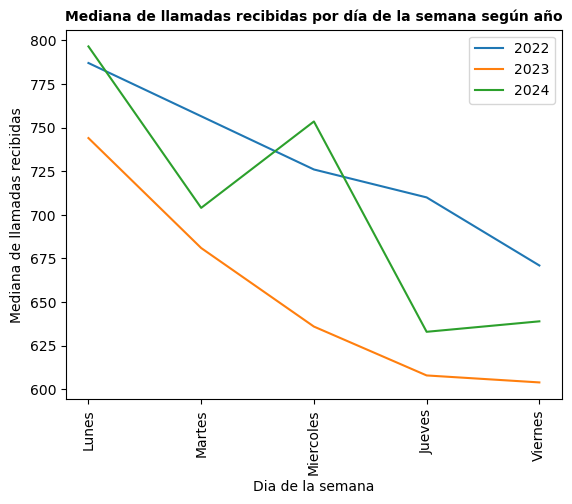

In [30]:
### Graficamos la mediana

df_calls_recibidas_dia_semana_median[[2022, 2023, 2024,]].plot()

plt.xticks(df_calls_recibidas_dia_semana_median.index,
                    ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes'], 
                    rotation = 90, 
                    fontsize = 10)
plt.xlabel("Dia de la semana")
plt.ylabel("Mediana de llamadas recibidas")
plt.legend(loc="upper right", fontsize=10)

plt.title("Mediana de llamadas recibidas por día de la semana según año", 
              fontsize=10,
              fontweight ="bold")
plt.show()

- Conclusiones: Podemos observar que en general el día de máxima demanda es el lunes y va cayendo a lo largo de la semana. Esto es razonable, ya que los clientes frecuentemente consultan sobre consumos del viernes post-horario de atención o del fin de semana. En el año 2024 observamos un pico los días miércoles, pero debemos considerar que contamos con menos meses para calcular las medidas de tendencia central y que en algunos casos los miércoles fueron el primer día hábil (en el caso de feriados puente), lo cual concentra un número excepcional de consultas.

### ANALISIS DIARIO (FRANJA HORARIA) POR TRIMESTRE

In [31]:
pd.crosstab(df['HORARIOS'], df['TRIMES'])

TRIMES    2022T1  2022T2  2022T3  2022T4  2023T1  2023T2  2023T3  2023T4  \
HORARIOS                                                                   
08:30         61      63      64      62      62      58      62      60   
09:00         61      64      64      62      62      58      62      60   
09:30         61      63      64      62      62      58      62      60   
10:00         61      63      64      62      62      58      62      60   
10:30         61      62      64      62      61      58      62      60   
11:00         60      64      64      62      61      58      62      60   
11:30         61      64      64      62      61      59      62      60   
12:00         61      64      64      63      61      58      62      60   
12:30         61      63      64      63      61      58      62      60   
13:00         61      64      64      62      61      58      62      60   
13:30         61      64      64      62      61      58      62      60   
14:00         61      64      64      62      61      58      62      60   
14:30         60      63      64      62      61      58      62      60   
15:00         60      62      63      62      61      58      62      60   
15:30         61      64      64      62      61      58      62      60   
16:00         61      64      64      62      61      58      62      60   
16:30         61      63      64      62      61      58      62      60   
17:00         61      63      64      62      61      58      62      60   
17:30         62      63      64      62      61      58      62      60   
18:00         61      63      64      64      61      58      62      60   
18:30         61      64      64      64      61      58      62      60   
19:00         61      64      64      64      61      58      62      60   
19:30         61      63      64      64      61      58      62      60   
20:00         61      63      64      64      61      58      62      60   
20:30         61      57      40      45      54      50      56      42   

TRIMES    2024T1  2024T2  
HORARIOS                  
08:30         61      32  
09:00         61      31  
09:30         61      31  
10:00         61      31  
10:30         61      31  
11:00         61      31  
11:30         61      31  
12:00         61      31  
12:30         61      30  
13:00         61      30  
13:30         62      30  
14:00         61      30  
14:30         61      30  
15:00         61      30  
15:30         61      30  
16:00         61      30  
16:30         61      30  
17:00         61      30  
17:30         61      30  
18:00         61      30  
18:30         61      30  
19:00         61      30  
19:30         61      30  
20:00         61      30  
20:30         54      28

In [32]:
df_calls_recibidas_intervalo = df.groupby(['HORARIOS', 'TRIMES'])\
                            .Llamadas_recibidas.sum()\
                            .reset_index()\
                            .pivot(index='HORARIOS', columns='TRIMES', values='Llamadas_recibidas')

In [33]:
df_calls_recibidas_intervalo_median = df.groupby(['HORARIOS', 'TRIMES'])\
                            .Llamadas_recibidas.median()\
                            .reset_index()\
                            .pivot(index='HORARIOS', columns='TRIMES', values='Llamadas_recibidas')

- Gráfico de tendencia (mediana) por trimestre e intervalo horario

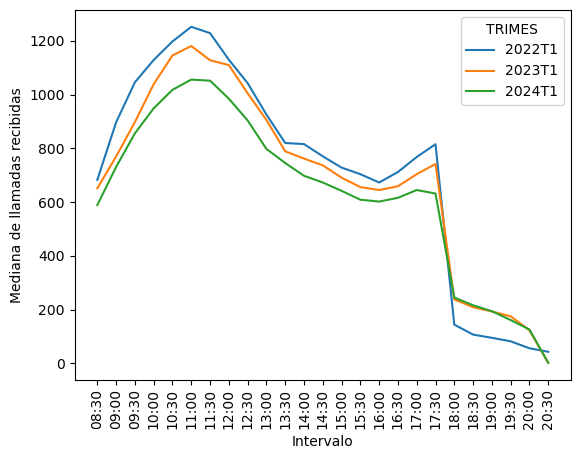

In [34]:
# 1 TRIMESTRE 
ticks = df_calls_recibidas_intervalo_median.index.astype(str)
df_calls_recibidas_intervalo_median[["2022T1","2023T1","2024T1"]].plot()

plt.xticks(range(len(ticks)), ticks, rotation=90, fontsize=10)
plt.xlabel("Intervalo")
plt.ylabel("Mediana de llamadas recibidas")
plt.show()

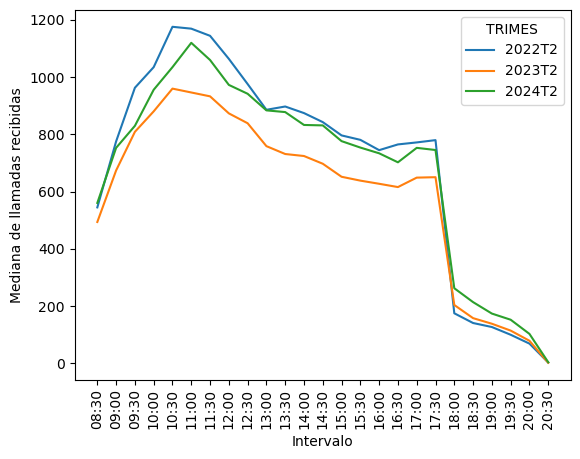

In [35]:
# 2 TRIMESTRE 
ticks = df_calls_recibidas_intervalo_median.index.astype(str)
df_calls_recibidas_intervalo_median[["2022T2","2023T2","2024T2"]].plot()

plt.xticks(range(len(ticks)), ticks, rotation=90, fontsize=10)
plt.xlabel("Intervalo")
plt.ylabel("Mediana de llamadas recibidas")
plt.show()

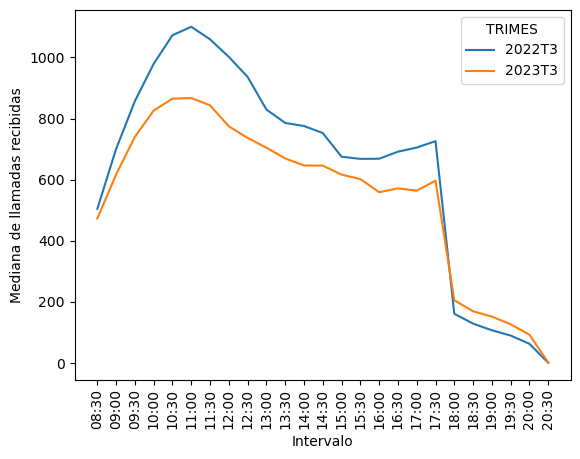

In [36]:
# 3 TRIMESTRE 
ticks = df_calls_recibidas_intervalo_median.index.astype(str)
df_calls_recibidas_intervalo_median[["2022T3","2023T3"]].plot()

plt.xticks(range(len(ticks)), ticks, rotation=90, fontsize=10)
plt.xlabel("Intervalo")
plt.ylabel("Mediana de llamadas recibidas")
plt.show()

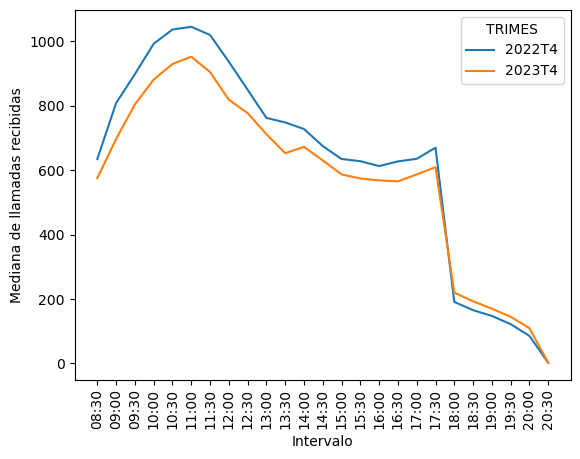

In [37]:
# 4 TRIMESTRE 
ticks = df_calls_recibidas_intervalo_median.index.astype(str)
df_calls_recibidas_intervalo_median[["2022T4","2023T4"]].plot()

plt.xticks(range(len(ticks)), ticks, rotation=90, fontsize=10)
plt.xlabel("Intervalo")
plt.ylabel("Mediana de llamadas recibidas")
plt.show()

Conclusiones: Si bien es sutil, observamos que en el 1 y 2 cuatrimestre del año los contactos se distribuyen mayoritariamente en la mañana, mientras que en en 3 y 4 lo hacen en horarios mas tardes. Atribuimos esto a la estacion del año y la extensión de las horas de luz.

### ANÁLISIS MENSUAL

In [38]:
pd.crosstab(df['DIAMES'], df['ANIO'])

ANIO    2022  2023  2024
DIAMES                  
1        198   173    50
2        173   199    67
3        198   224    75
4        223   200    75
5        198   199   100
6        199   224    75
7        250   200    75
8        207   175   124
9        177   199   100
10       198   224    75
11       224   199    74
12       199   199    75
13       200   225    50
14       224   225    74
15       219   199   124
16       197   175   100
17       195   225    75
18       219   197    75
19       200   173    99
20       171   173    57
21       240   151    57
22       225   200   100
23       197   197    73
24       192   196    50
25       219   125    75
26       174   148   100
27       200   249    50
28       210   224    50
29       196   173    52
30       175   173    25
31       124   148    25

### Cantidad de llamadas recibidas por dia del mes del año // SUMA

In [39]:
df_calls_recibidas_dia_mes = df.groupby(['DIAMES', 'ANIO'])\
                            .Llamadas_recibidas.sum()\
                            .reset_index()\
                            .pivot(index='DIAMES', columns='ANIO', values='Llamadas_recibidas')

### Cantidad de llamadas recibidas por día del mes del año // MEDIANA

In [40]:
df_calls_recibidas_dia_mes_median = df.groupby(['DIAMES', 'ANIO'])\
                            .Llamadas_recibidas.median()\
                            .reset_index()\
                            .pivot(index='DIAMES', columns='ANIO', values='Llamadas_recibidas')

- Gráfico de variación mensual en las llamadas recibidas (mediana) en 2022, 2023 y 2024.

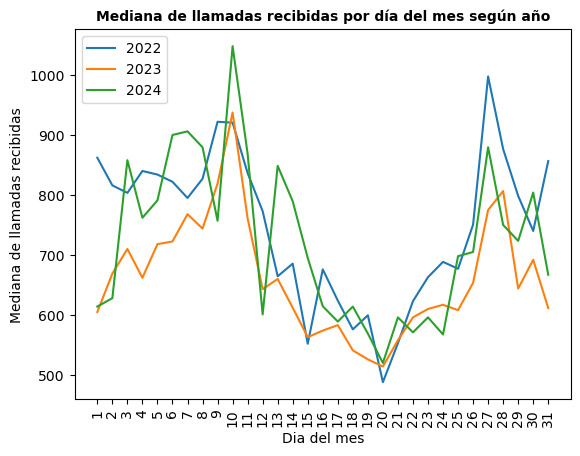

In [41]:
df_calls_recibidas_dia_mes_median[[2022, 2023, 2024]].plot()

plt.xticks(df_calls_recibidas_dia_mes_median.index, 
                    rotation = 90, 
                    fontsize = 10)
plt.xlabel("Dia del mes")
plt.ylabel("Mediana de llamadas recibidas")
plt.legend(loc="upper left", fontsize=10)

plt.title("Mediana de llamadas recibidas por día del mes según año", 
            fontsize=10,
            fontweight ="bold")
plt.show()

Conclusiones: los días de cierre y de pago muestran picos estables a lo largo de los años, por un aumento en las consultas relacionadas a la liquidación de los servicios financieros.

### ANÁLISIS SEMANAL + DIARIO DE DEMANDA DEL SERVICIO DE ATENCIÓN

In [46]:
df['INICIO_INTERVALO'] = pd.to_datetime(df['INICIO_INTERVALO'])
periodos_filtros = ['PERIODO_CIERRE', 'PERIODO_PAGO', 'PERIODO_RESTO_MES']
df_filtrado = df[df[periodos_filtros].sum(axis=1) > 0]

#Agrupar por año, día de la semana y hora del día, y calculamos la suma de llamadas recibidas 
grupo_llamadas = df_filtrado.groupby([df_filtrado['ANIO'], df_filtrado['INICIO_INTERVALO'].dt.day_name(), df_filtrado['INICIO_INTERVALO'].dt.hour]).apply(lambda x: x['Llamadas_recibidas'].sum())

#Buscamos periodos con mayor trafico de llamadas
periodos_con_mayor_volumen_por_año = grupo_llamadas.groupby(level=[0]).idxmax()

for año, idx in periodos_con_mayor_volumen_por_año.items():
    dia_semana, hora_inicio = idx[1], idx[2]
    hora_legible = f"{hora_inicio}:00 - {hora_inicio+1}:00"
    print(f"Año: {año}, Día de la semana: {dia_semana}, Período con mayor volumen: {hora_legible}")


Año: 2022, Día de la semana: Tuesday, Período con mayor volumen: 11:00 - 12:00
Año: 2023, Día de la semana: Wednesday, Período con mayor volumen: 11:00 - 12:00
Año: 2024, Día de la semana: Wednesday, Período con mayor volumen: 11:00 - 12:00


Conclusiones: Vemos que los picos de llamadas recibidas por el Centro de Atencion al Cliente oscilan en el mismo rango horario de 11am a 12pm, y que los días de mayor tráfico son Martes y Miércoles según el histórico. 

<u> - Conclusiones etapa de exploración: Este análisis nos permite ver tendencias claras en cuanto a la demanda del servicio que serán de gran valor al intentar predecir el volumen de llamadas futuras, especialmente teniendo en cuenta el comportamiento del cliente con respecto al día de la semana y franja horaria (este último punto de análisis) que es el más importante a la hora de evaluar la demanda high level. 

In [47]:
# Funcion para analisis de errores para cada modelo
def errores(y_true, y_pred):
    mse = round(mean_squared_error(y_true, y_pred), 2) #Redondear a dos decimales 
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    rmse = round(np.sqrt(mse), 2)
    r2 = round(r2_score(y_true, y_pred), 2)
    return mse, mae, r2, rmse

## Modelo baseline de forecasting: Single Exponential Smoothing

Recordamos las columnas del dataframe y tomamos una muestra para observar los datos

In [48]:
df.columns

Index(['RN', 'FECHA', 'INICIO_INTERVALO', 'Llamadas_recibidas',
       'Llamadas_atendidas', 'PERIODO_CIERRE', 'PERIODO_PAGO',
       'PERIODO_RESTO_MES', 'FECHA_ENVIO_RDC', 'FECHA.1', 'ANIO', 'MES',
       'TRIMES', 'DIASEM', 'DIAMES', 'DIAAANIO', 'SEMANA', 'DIA_HABIL',
       'timeIndex', 'HORARIOS'],
      dtype='object')

In [49]:
df.sample()

RN      FECHA          INICIO_INTERVALO  \
INICIO_INTERVALO                                               
2024-05-03 13:00  15209 2024-05-03 2024-05-03 13:00:00+00:00   

                  Llamadas_recibidas  Llamadas_atendidas  PERIODO_CIERRE  \
INICIO_INTERVALO                                                           
2024-05-03 13:00                 998                 872               0   

                  PERIODO_PAGO  PERIODO_RESTO_MES  FECHA_ENVIO_RDC  \
INICIO_INTERVALO                                                     
2024-05-03 13:00             1                  0                0   

                     FECHA.1  ANIO     MES  TRIMES  DIASEM  DIAMES  DIAAANIO  \
INICIO_INTERVALO                                                               
2024-05-03 13:00  2024-05-03  2024  202405  2024T2       6       3       124   

                  SEMANA  DIA_HABIL  timeIndex HORARIOS  
INICIO_INTERVALO                                         
2024-05-03 13:00      18          1      15208    13:00

In [50]:
columnas_a_eliminar = ['RN', 'FECHA', 'INICIO_INTERVALO',
       'Llamadas_atendidas', 'PERIODO_CIERRE', 'PERIODO_PAGO',
       'PERIODO_RESTO_MES', 'FECHA_ENVIO_RDC', 'FECHA.1', 'ANIO', 'MES',
       'TRIMES', 'DIASEM', 'DIAMES', 'DIAAANIO', 'SEMANA', 'DIA_HABIL',
       'timeIndex', 'HORARIOS']

df_SES = df.drop(columns=columnas_a_eliminar).resample('W').mean().rename_axis("INTERVALO SEMANAL")

In [51]:
df_SES.head(3)

Llamadas_recibidas
INTERVALO SEMANAL                        
2022-01-03/2022-01-09             711.296
2022-01-10/2022-01-16             729.024
2022-01-17/2022-01-23             601.528

Dividimos en subconjuntos de train y test específicos para este modelo simplificado (donde no tomamos más features que las fluctuaciones en el tiempo)

In [52]:
df_SES_train, df_SES_test = train_test_split(df_SES, test_size=0.35, random_state=10, shuffle=False)

Corroboramos el armado de grupos semanales y observamos en qué momento termina el set de entrenamiento y cuándo comienza el de prueba.

In [53]:
df_SES_train.tail().round(2)

Llamadas_recibidas
INTERVALO SEMANAL                        
2023-06-19/2023-06-25              605.16
2023-06-26/2023-07-02              640.47
2023-07-03/2023-07-09              635.89
2023-07-10/2023-07-16              689.67
2023-07-17/2023-07-23              457.46

In [54]:
df_SES_test.head().round(2)

Llamadas_recibidas
INTERVALO SEMANAL                        
2023-07-24/2023-07-30              591.84
2023-07-31/2023-08-06              549.30
2023-08-07/2023-08-13              695.68
2023-08-14/2023-08-20              466.81
2023-08-21/2023-08-27              503.39

Probaremos tres modelos con un nivel de smoothing alpha de 0.1, 0.5 y 0.9 para observar las diferencias en el ajuste al conjunto test, y realizamos el forecast cubriendo el período "test"

In [55]:
# Define smoothing factors
smoothing_factors = [0.1, 0.5, 0.9]

# Fit del modelo SES
models = {}
for alpha in smoothing_factors:
    model_key = f"model_smoothing_{alpha:.2f}"
    models[model_key] = SimpleExpSmoothing(df_SES_test.Llamadas_recibidas).fit(smoothing_level=alpha, optimized=False)


In [56]:
# Sumamos forecasts
for alpha, model in models.items():
    df_SES_test[f"forecast_{alpha[-4:]}"] = model.fittedvalues

df_SES_test.head()

Llamadas_recibidas  forecast_0.10  forecast_0.50  \
INTERVALO SEMANAL                                                         
2023-07-24/2023-07-30             591.840     591.840000        591.840   
2023-07-31/2023-08-06             549.304     591.840000        591.840   
2023-08-07/2023-08-13             695.680     587.586400        570.572   
2023-08-14/2023-08-20             466.808     598.395760        633.126   
2023-08-21/2023-08-27             503.390     585.236984        549.967   

                       forecast_0.90  
INTERVALO SEMANAL                     
2023-07-24/2023-07-30     591.840000  
2023-07-31/2023-08-06     591.840000  
2023-08-07/2023-08-13     553.557600  
2023-08-14/2023-08-20     681.467760  
2023-08-21/2023-08-27     488.273976

- Análisis comparativo de la performance de los modelos

In [57]:
# Diccionarios para almacenar las métricas
metrics = {}

# Calcular métricas para cada modelo
for alpha, model in models.items():
    forecast_column = f"forecast_{alpha[-4:]}"
    
    # Valores reales y predichos
    y_true = df_SES_test.Llamadas_recibidas
    y_pred = df_SES_test[forecast_column]
    
    # Calcular métricas
    mse, mae, r2, rmse = errores(y_true, y_pred)
    # Almacenar métricas en el diccionario
    metrics[alpha] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Imprimir métricas
for alpha, metric in metrics.items():
    print(f"Métricas del modelo con smoothing factor {alpha[-4:]}:")
    print(f"  RMSE: {metric['RMSE']:.2f}")
    print(f"  MAE: {metric['MAE']:.2f}")
    print(f"  R2: {metric['R2']:.2f}")
    print()

Métricas del modelo con smoothing factor 0.10:
  RMSE: 101.83
  MAE: 82.47
  R2: 0.08

Métricas del modelo con smoothing factor 0.50:
  RMSE: 112.26
  MAE: 92.86
  R2: -0.11

Métricas del modelo con smoothing factor 0.90:
  RMSE: 122.97
  MAE: 100.08
  R2: -0.34



- Visualizaciones

In [58]:
# Realizamos un cambio del tipo del índice de "period" a "string" para que pueda ser empleado como eje del gráfico
df_SES_test.index = df_SES_test.index.astype(str)

# Graficar los datos reales y las predicciones de los tres modelos
trace_real = go.Scatter(x=df_SES_test.index, y=df_SES_test['Llamadas_recibidas'], mode='lines', name='Datos Reales')

traces_forecasts = []
for alpha, model in models.items():
    forecast_column = f"forecast_{alpha[-4:]}"
    trace_forecast = go.Scatter(x=df_SES_test.index, y=df_SES_test[forecast_column], mode='lines', name=f'Pronóstico (α={alpha[-4:]})')
    traces_forecasts.append(trace_forecast)

# Crear el diseño del gráfico
layout = go.Layout(title='Predicciones de los Modelos de Suavizado Exponencial Simple vs. Datos Reales (Período Test)',
                   xaxis_title='Fecha',
                   yaxis_title='Llamadas Recibidas',
                   width=1000,
                   height=600)

fig = go.Figure(data=[trace_real] + traces_forecasts, layout=layout)
fig.show()

In [59]:
# Calcular las diferencias entre los valores pronosticados y los valores reales
for alpha, model in models.items():
    forecast_column = f"forecast_{alpha[-4:]}"
    df_SES_test[f"diff_{alpha[-4:]}"] = df_SES_test[forecast_column] - df_SES_test['Llamadas_recibidas']

# Crear trazos para las diferencias de cada modelo
traces_diff = []
for alpha, model in models.items():
    diff_column = f"diff_{alpha[-4:]}"
    trace_diff = go.Bar(x=df_SES_test.index, y=df_SES_test[diff_column], name=f'Diferencia (α={alpha[-4:]})')
    traces_diff.append(trace_diff)

# Crear el diseño del gráfico
layout_diff = go.Layout(title='Diferencia entre Valores Pronosticados y Datos Reales (Período Test)',
                        xaxis_title='Fecha',
                        yaxis_title='Diferencia',
                        width=1000,
                        height=600)

# Combinar los trazos y el diseño en un objeto figura
fig_diff = go.Figure(data=traces_diff, layout=layout_diff)

# Mostrar el gráfico interactivo
fig_diff.show()

# Guardamos el mejor modelo de suavizado exponencial simple
best_model_SES = models['model_smoothing_0.10']

In [60]:
# Calcular residuos para cada modelo
residuals = {}
for alpha, model in models.items():
    forecast_column = f"forecast_{alpha[-4:]}"
    residuals[alpha] = df_SES_test['Llamadas_recibidas'] - df_SES_test[forecast_column]



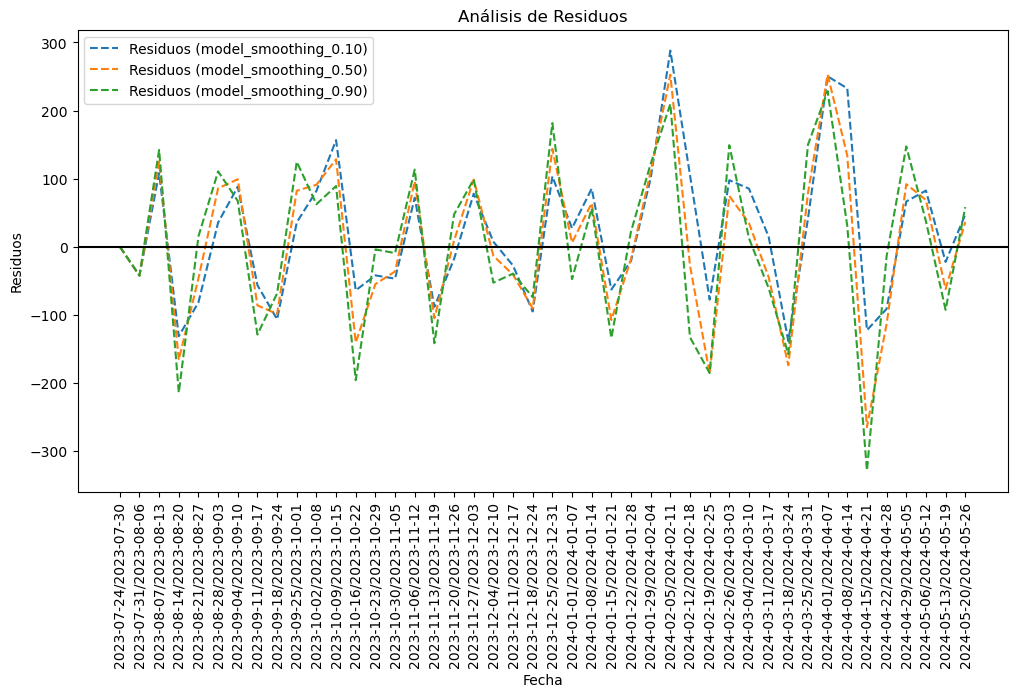

In [61]:
# Crear figura y ejes
plt.figure(figsize=(12, 6))

# Graficar residuos para cada modelo
for alpha, res in residuals.items():
    plt.plot(df_SES_test.index, res, label=f'Residuos ({alpha})', linestyle='--')

# Línea horizontal en y=0
plt.axhline(y=0, color='black', linestyle='-')

# Títulos y etiquetas
plt.title('Análisis de Residuos')
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.xticks(rotation=90)  

# Mostrar leyenda
plt.legend()

# Mostrar gráfico
plt.show()

- Conclusiones Single Exponential Smoothing (SES)

Los smoothing factors más altos están generando predicciones menos precisas y con mayores errores. Esto es consistente con el hecho de que los mismos, en este contexto, hacen que el modelo responda más a las fluctuaciones recientes en los datos, lo que puede introducir más ruido y menos estabilidad en la predicción. Otros modelos de series temporales más complejos pueden detectar si los datos tienen patrones que el SES no puede capturar adecuadamente.

Aún en el modelo con mejor performance, la varianza de la serie temporal es explicada en muy baja medida por el modelo (R2=0.02), mientras que en los smoothings más altos, al darle más peso a los datos más recientes, el modelo se vuelve muy sensible a las fluctuaciones y capta ruido y variabilida aleatoria en lugar de tendencias subyacentes (recordemos que ninguno de los modelos considera estacionalidad, tendencia etc.)

## Preparamos el dataset para definir las features mas relevantes para futuros modelos

In [62]:
df_gb = df

Eliminamos los nulos sobre todas las columnas considerando que todas pueden ser relevantes. 

In [63]:
df_gb['PERIODO_CIERRE'] = df_gb['PERIODO_CIERRE'].apply(lambda x: 1 if x == 1.0 else 0)
df_gb['PERIODO_PAGO'] = df_gb['PERIODO_PAGO'].apply(lambda x: 1 if x == 1.0 else 0)
df_gb['PERIODO_RESTO_MES'] = df_gb['PERIODO_RESTO_MES'].apply(lambda x: 1 if x == 1.0 else 0)

Creamos una columna para que nuestros modelos de gradient boosting puedan analizar las variables como categoricas a fin de estandarizar todas las features

In [64]:
# Creamos la columna turnos
df_gb['Turnos'] = df['HORARIOS'].factorize()[0] + 1
df_gb[['Turnos','HORARIOS']].value_counts().sort_index()

Turnos  HORARIOS
1       08:30       585
2       09:00       585
3       09:30       584
4       10:00       584
5       10:30       582
6       11:00       583
7       11:30       585
8       12:00       585
9       12:30       583
10      13:00       583
11      13:30       584
12      14:00       583
13      14:30       581
14      15:00       579
15      15:30       583
16      16:00       583
17      16:30       582
18      17:00       582
19      17:30       583
20      18:00       584
21      18:30       585
22      19:00       585
23      19:30       584
24      20:00       584
25      20:30       487
Name: count, dtype: int64

In [65]:
# Features
df_gb_num = df.select_dtypes(include=[np.number])
X_tree  = df_gb_num.drop(columns=['Llamadas_recibidas'])

# target
y_tree = df_gb['Llamadas_recibidas']

In [66]:
X_tree.head()

RN  Llamadas_atendidas  PERIODO_CIERRE  PERIODO_PAGO  \
INICIO_INTERVALO                                                         
2022-01-03 08:30   2                 697               0             1   
2022-01-03 09:00   3                 873               0             1   
2022-01-03 09:30   4                1120               0             1   
2022-01-03 10:00   5                1219               0             1   
2022-01-03 10:30   6                1066               0             1   

                  PERIODO_RESTO_MES  FECHA_ENVIO_RDC  ANIO     MES  DIASEM  \
INICIO_INTERVALO                                                             
2022-01-03 08:30                  0                0  2022  202201       2   
2022-01-03 09:00                  0                0  2022  202201       2   
2022-01-03 09:30                  0                0  2022  202201       2   
2022-01-03 10:00                  0                0  2022  202201       2   
2022-01-03 10:30                  0                0  2022  202201       2   

                  DIAMES  DIAAANIO  SEMANA  DIA_HABIL  timeIndex  Turnos  
INICIO_INTERVALO                                                          
2022-01-03 08:30       3         3       1          1          1       1  
2022-01-03 09:00       3         3       1          1          2       2  
2022-01-03 09:30       3         3       1          1          3       3  
2022-01-03 10:00       3         3       1          1          4       4  
2022-01-03 10:30       3         3       1          1          5       5

Usamos Decision Tree para analizar las features más relevantes para nuestras predicciones

In [67]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_tree,y_tree,test_size=0.2, shuffle=False)


# Entrenamos el modelo de árbol de decisión con CART
model_features = DecisionTreeRegressor(criterion='squared_error')
model_features.fit(X_train_fe, y_train_fe)

# Calculamos la importancia de las características
feature_importance = model_features.feature_importances_

df_feature_importance = pd.DataFrame({'Feature': X_train_fe.columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)


df_feature_importance.head(7)

Feature  Importance
1   Llamadas_atendidas    0.911265
10            DIAAANIO    0.017523
0                   RN    0.016722
14              Turnos    0.013881
13           timeIndex    0.012591
9               DIAMES    0.007312
8               DIASEM    0.006110

In [68]:
# Seleccionamos los nombres de las 7 características más importantes
top_features = df_feature_importance.head(7)['Feature'].tolist()

# Creamos la variable X con esas características
X_tree_col = df_gb[top_features]

## MODELO REGRESION LINEAL

Este modelo nos permite realizar una predicción simple y fácilmente interpretable de las llamadas a recibir. Además, lás métricas obtenidas también sirven como panorama general de tendencias y como base para aplicar modelos más complejos como los que se desarrollarán a continuación.

In [69]:
model_lin = sm.OLS(y_tree, X_tree_col).fit()


print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:     Llamadas_recibidas   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                 2.117e+04
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        09:12:03   Log-Likelihood:                -90399.
No. Observations:               14488   AIC:                         1.808e+05
Df Residuals:                   14481   BIC:                         1.809e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Llamadas_atendidas     1.1138      0

In [70]:
y_pred_lin = model_lin.predict(X_test_fe[top_features])

In [71]:
mse, mae, r2, rmse = errores(y_test_fe, y_pred_lin)
print(f'MAE Regresion Lineal:{mae}')
print(f'MSE Regresion Lineal:{mse}')
print(f'R2 Regresion Lineal:{r2}')
print(f'RMSE Regresion Lineal:{rmse}')


MAE Regresion Lineal:81.76
MSE Regresion Lineal:17332.98
R2 Regresion Lineal:0.87
RMSE Regresion Lineal:131.65


- Conclusiones: el modelo presenta un buen ajuste con un R2 de 87%, con errores de predicción (MAE y RMSE) a considerar para predicciones individuales. Esto puede deberse particularmente a que no se están teniendo en consideración las variables exógenas como día de la semana, franja horaria etc. a la hora de realizar la predicción, por lo cual en casos de picos o valles puede existir un residuo ostensible entre predichos y reales.

Por otro lado, se deben tener en cuenta los supuestos del modelo (linealidad, independencia, homocedasticidad y normalidad de los residuos) que en este caso pueden llevar parte de la causa del error.

In [72]:
# Convertimos el índice a formato numérico
residuals = y_test_fe - y_pred_lin
residuals.index = residuals.index.to_timestamp()

In [73]:
# guardamos el modelo de regresion lineal
model_lin.save('model_lin.pkl')

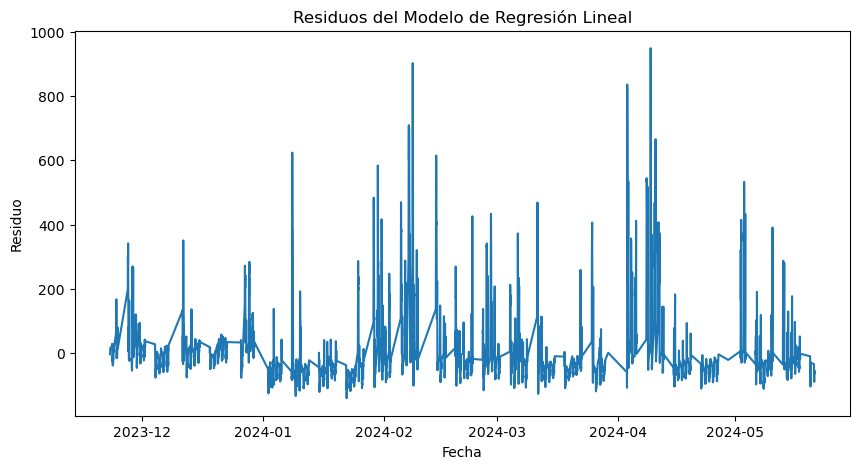

In [74]:
# Graficar los residuos
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuos del Modelo de Regresión Lineal')
plt.xlabel('Fecha')
plt.ylabel('Residuo')
plt.show()

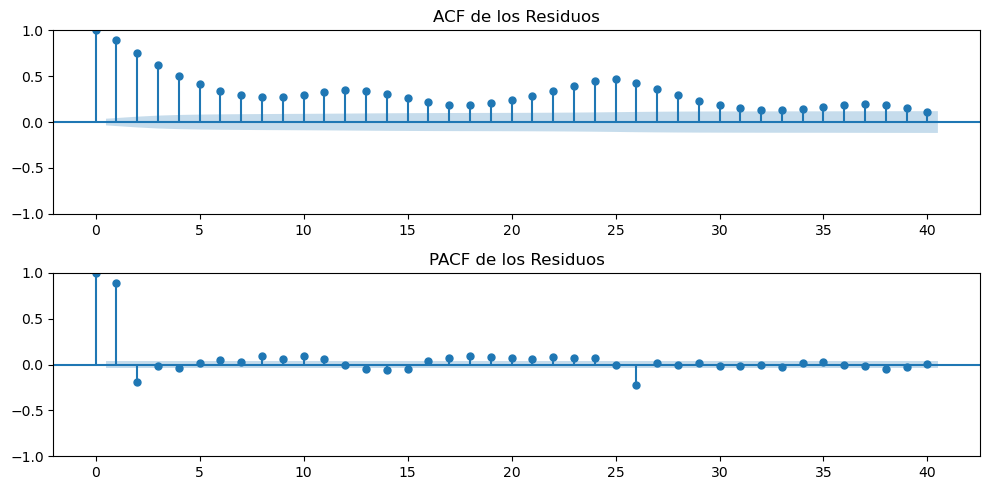

In [75]:
# Graficamos ACF y PACF de los residuos
plt.figure(figsize=(10, 5))
plt.subplot(211)
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos')
plt.subplot(212)
plot_pacf(residuals, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos')
plt.tight_layout()
plt.show()

Podemos ver que hay una autocorrelacion alta por lo que consideramos usar el odelo ARIMA para manejar esta autocorrelación. 

## ARIMA - SARIMAX

In [76]:
print(df.columns)

Index(['RN', 'FECHA', 'INICIO_INTERVALO', 'Llamadas_recibidas',
       'Llamadas_atendidas', 'PERIODO_CIERRE', 'PERIODO_PAGO',
       'PERIODO_RESTO_MES', 'FECHA_ENVIO_RDC', 'FECHA.1', 'ANIO', 'MES',
       'TRIMES', 'DIASEM', 'DIAMES', 'DIAAANIO', 'SEMANA', 'DIA_HABIL',
       'timeIndex', 'HORARIOS', 'Turnos'],
      dtype='object')


In [77]:
df_SARIMAX = df.drop(columns=['INICIO_INTERVALO','HORARIOS', 'FECHA.1'])

df_SARIMAX['MES'] = df_SARIMAX['MES'].astype(str)
df_SARIMAX['TRIMES'] = df_SARIMAX['TRIMES'].astype(str)

# Eliminar los primeros 4 números de la columna 'MES' para que solo contenga el número del mes
df_SARIMAX['MES'] = df_SARIMAX['MES'].str.slice(start=4)

# Eliminar los primeros 4 números y la letra 'T' final de la columna 'TRIMES'
df_SARIMAX['TRIMES'] = df_SARIMAX['TRIMES'].str.slice(start=4).str.replace('T', '')

df_SARIMAX['MES'] = df_SARIMAX['MES'].astype(int)
df_SARIMAX['TRIMES'] = df_SARIMAX['TRIMES'].astype(int)

# Evaluamos que se haya realizado bien el reemplazo
df_SARIMAX.sample()

RN      FECHA  Llamadas_recibidas  Llamadas_atendidas  \
INICIO_INTERVALO                                                             
2023-11-23 16:00  12503 2023-11-23                 509                 485   

                  PERIODO_CIERRE  PERIODO_PAGO  PERIODO_RESTO_MES  \
INICIO_INTERVALO                                                    
2023-11-23 16:00               0             0                  1   

                  FECHA_ENVIO_RDC  ANIO  MES  TRIMES  DIASEM  DIAMES  \
INICIO_INTERVALO                                                       
2023-11-23 16:00                0  2023   11       4       5      23   

                  DIAAANIO  SEMANA  DIA_HABIL  timeIndex  Turnos  
INICIO_INTERVALO                                                  
2023-11-23 16:00       327      47          1      12502      16

In [78]:
# Evaluamos que los tipos remanentes sean numéricos
df_SARIMAX.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 14488 entries, 2022-01-03 08:30 to 2024-05-21 12:00
Freq: 30T
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   RN                  14488 non-null  int64         
 1   FECHA               14488 non-null  datetime64[ns]
 2   Llamadas_recibidas  14488 non-null  int64         
 3   Llamadas_atendidas  14488 non-null  int64         
 4   PERIODO_CIERRE      14488 non-null  int64         
 5   PERIODO_PAGO        14488 non-null  int64         
 6   PERIODO_RESTO_MES   14488 non-null  int64         
 7   FECHA_ENVIO_RDC     14488 non-null  int64         
 8   ANIO                14488 non-null  int32         
 9   MES                 14488 non-null  int32         
 10  TRIMES              14488 non-null  int32         
 11  DIASEM              14488 non-null  int64         
 12  DIAMES              14488 non-null  int64         
 13  DIAAANIO 

Como pre-requisito para esta serie de modelos (SARIMAX y ARIMA), realizaremos el test ADF para evaluar si la serie cumple con la condición de estacionariedad.

In [79]:
adf_test = sm.tsa.adfuller(df_SARIMAX['Llamadas_recibidas'])
p_valor = adf_test[1]
print("p-valor de la prueba ADF:", p_valor)

if p_valor < 0.05:
    print("Un p-valor significativo en la prueba de Dickey-Fuller aumentada (ADF) nos indica que la serie es estacionaria, por lo tanto, cumple con los requisitos para el modelo SARIMAX.")
else:
    print("Un p-valor no significativo en la prueba de Dickey-Fuller aumentada (ADF) nos indica que la serie NO es estacionaria y debe trabajarse antes de poner a punto un modelo SARIMAX.")

p-valor de la prueba ADF: 1.2829238797845723e-19
Un p-valor significativo en la prueba de Dickey-Fuller aumentada (ADF) nos indica que la serie es estacionaria, por lo tanto, cumple con los requisitos para el modelo SARIMAX.


In [80]:
# Dividimos el dataset en entrenamiento (80%) y prueba (20%)
train_size = int(len(df_SARIMAX) * 0.8)
train, test = df_SARIMAX[:train_size], df_SARIMAX[train_size:]

# confirmamos que 'Llamadas_recibidas' es la serie temporal que analizamos
adf_train = train['Llamadas_recibidas']

adf_test = sm.tsa.adfuller(adf_train)
p_valor = adf_test[1]

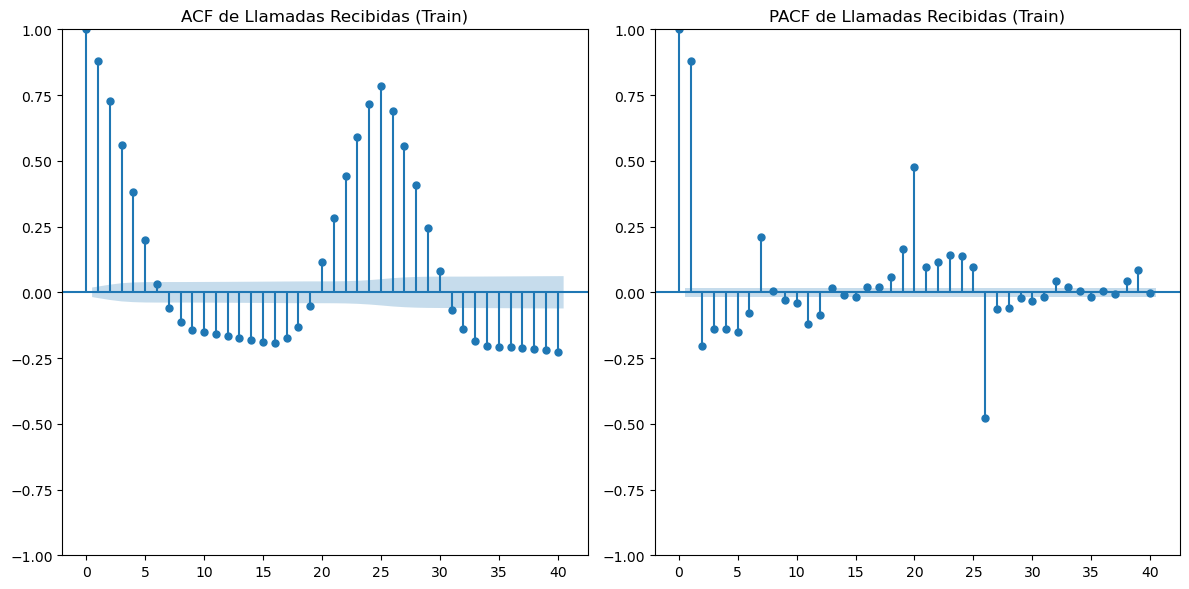

In [81]:
# Graficamos ACF y PACF
plt.figure(figsize=(12, 6))

# Gráfico ACF
plt.subplot(121)
plot_acf(adf_train, lags=40, ax=plt.gca())
plt.title('ACF de Llamadas Recibidas (Train)')

# Gráfico PACF
plt.subplot(122)
plot_pacf(adf_train, lags=40, ax=plt.gca())
plt.title('PACF de Llamadas Recibidas (Train)')

plt.tight_layout()
plt.show()

Los gráficos muestran una correlación significativa en los primeros lags. Esto indica que las llamadas recibidas por el call center están correlacionadas con las llamadas recibidas en los períodos de tiempo anteriores. Lo cual es útil para prever el volumen futuro de llamadas utilizando modelos de series temporales como ARIMA, SARIMA y SARIMAX.

Definimos la variable endógena (dependiente, target) y las exógenas a ser consideradas en este modelo. 

In [82]:
endog = df_SARIMAX['Llamadas_recibidas']
exog = df_SARIMAX[['PERIODO_CIERRE', 'PERIODO_PAGO', 'PERIODO_RESTO_MES', 'FECHA_ENVIO_RDC',
                   'ANIO', 'MES', 'TRIMES', 'DIAMES', 'DIASEM', 'SEMANA', 'DIAAANIO', 'DIA_HABIL']]

## ARIMA

Este modelo permite capturar patrones más complejos que los modelos anteriores gracias a los componentes auto-regresivo (consideración de comportamiento histórico de la serie), media móvil e integración. Sin embargo, en esta versión no se captura la estacionalidad. Esperamos que su desempeño sea algo más robusto que en otros modelos simples.

In [83]:
# Dividir en entrenamiento y prueba
train, test = train_test_split(endog, test_size=0.2, shuffle=False)

In [84]:
# Ajuste automático del modelo ARIMA con validación cruzada
modelo = pm.auto_arima(train, seasonal=False, trace=True, suppress_warnings=True, stepwise=True, d=0) #Como es una serie estacionaria to,o d=0

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=154437.582, Time=1.91 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=186840.075, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=154767.569, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=174105.717, Time=1.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=154485.779, Time=1.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=154442.219, Time=1.01 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=154233.287, Time=4.23 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=154439.311, Time=2.46 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=154298.211, Time=4.47 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=153995.049, Time=7.38 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=154334.981, Time=3.25 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=154264.644, Time=8.59 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=153752.201, Time=8.41 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=154129.280, Time=3.34 sec
 ARIM

In [90]:
# Ajustar el modelo ARIMA con statsmodels usando los mejores parámetros
model_arima = ARIMA(train, order=(5, 0, 5))
model_fit = model_arima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     Llamadas_recibidas   No. Observations:                11590
Model:                 ARIMA(5, 0, 5)   Log Likelihood              -76090.405
Date:                Thu, 23 May 2024   AIC                         152204.810
Time:                        09:19:09   BIC                         152293.104
Sample:                    01-03-2022   HQIC                        152234.479
                         - 11-22-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        657.1700      9.931     66.171      0.000     637.705     676.635
ar.L1          0.5233      0.031     17.132      0.000       0.463       0.583
ar.L2         -0.0970      0.041     -2.389      0.0

In [91]:
# Generar predicciones
forecast = model_fit.forecast(steps=len(test))

In [92]:
# guardamos el modelo ARIMA
model_fit.save('model_arima.pkl')

In [93]:
# Evaluación del modelo
mse, mae, r2, rmse = errores(test, forecast)
print("Error cuadrático medio (MSE):", mse)
print("Error absoluto medio (MAE):", mae)
print("Raíz del error cuadrático medio (RMSE):", rmse)
print("Coeficiente de determinación (R2):", r2)

Error cuadrático medio (MSE): 130887.39
Error absoluto medio (MAE): 285.73
Raíz del error cuadrático medio (RMSE): 361.78
Coeficiente de determinación (R2): 0.0


### SARIMAX

A priori, este modelo ofrece algunas ventajas promisorias para los objetivos planteados, especialmente con respecto a ARIMA.
- Captura de Estacionalidad, las Tendencias y los Ciclos (si los hay) ("S")
- Inclusión de Variables Exógenas ("X")
- Combinación y validación cruzada de todos los componentes.

In [94]:
# Iteración mejores parámetros p, d y q (componente autorregresivo, de diferenciación y de media móvil + estacionalidad)
#p = d = q = range(0, 2)
#pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#def evaluate_params(param, param_seasonal):
    #try:
        #mod = sm.tsa.SARIMAX(endog, exog=exog, order=param, seasonal_order=param_seasonal)
        #results = mod.fit(disp=False)
        #return (results.aic, param, param_seasonal)
    #except:
        #return (np.inf, param, param_seasonal)

# Evaluar todas las combinaciones en paralelo
#results = Parallel(n_jobs=-1)(delayed(evaluate_params)(param, param_seasonal) for param in pdq for param_seasonal in seasonal_pdq)

# Seleccionar el mejor conjunto de parámetros
#best_aic, best_param, best_param_seasonal = min(results, key=lambda x: x[0])

In [95]:
# Incorporación de "best params" definidos por CV (ver annotation)
best_param = (0, 1, 0)
best_param_seasonal = (0, 0, 0, 12)

print('Mejores parámetros:', best_param, best_param_seasonal)

Mejores parámetros: (0, 1, 0) (0, 0, 0, 12)


In [96]:
# Ajustar el modelo SARIMAX con los mejores parámetros resultantes
mod_sarimax = sm.tsa.SARIMAX(endog, exog=exog, order=best_param, seasonal_order=best_param_seasonal)
results = mod_sarimax.fit()

# Definir y separar conjuntos train y test
n_train = int(0.80 * len(df_SARIMAX))
train_data = df_SARIMAX.iloc[:n_train]
test_data = df_SARIMAX.iloc[n_train:]

# Predicciones modelo SARIMAX
predictions = results.predict(start=test_data.index[0], end=test_data.index[-1], 
                              exog=test_data[['PERIODO_CIERRE', 'PERIODO_PAGO', 'PERIODO_RESTO_MES', 'FECHA_ENVIO_RDC',
       'ANIO', 'MES', 'TRIMES', 'DIAMES', 'DIASEM', 'SEMANA', 'DIAAANIO','DIA_HABIL']])

In [97]:
mse, mae, r2, rmse = errores(test_data['Llamadas_recibidas'], predictions)
print("Error cuadrático medio (MSE):", mse)
print("Error absoluto medio (MAE):", mae)
print("Raíz del error cuadrático medio (RMSE):", rmse)
print("Coeficiente de determinación (R2):", r2)

Error cuadrático medio (MSE): 21834.94
Error absoluto medio (MAE): 91.79
Raíz del error cuadrático medio (RMSE): 147.77
Coeficiente de determinación (R2): 0.83


In [98]:
# Nos aseguramos de que las predicciones tienen el mismo índice que los datos de prueba
predictions = predictions[:len(test_data)]
predictions.index = test_data.index

# Activar si no corren los gráficos
test_data.index = test_data.index.astype(str)
train_data.index = train_data.index.astype(str)
predictions.index = predictions.index.astype(str)

In [99]:
#guardamos el modelo SARIMAX
results.save('model_sarimax.pkl')

In [100]:
# Crear una figura interactiva con plotly
fig = go.Figure()

# Añadir la serie de entrenamiento
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['Llamadas_recibidas'],
                         mode='lines', name='Entrenamiento'))

# Añadir la serie de datos reales
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Llamadas_recibidas'],
                         mode='lines', name='Real'))

# Añadir la serie de predicciones
fig.add_trace(go.Scatter(x=test_data.index, y=predictions,
                         mode='lines', name='Predicción'))

# Añadir el diseño del gráfico
fig.update_layout(title='Predicciones de llamadas recibidas usando SARIMAX',
                  xaxis_title='Fecha',
                  yaxis_title='Llamadas recibidas')

fig.show()

In [101]:
# Calcular los errores de predicción
errors = test_data['Llamadas_recibidas'] - predictions

# Crear una figura interactiva con plotly
fig = go.Figure()

# Añadir la serie de errores
fig.add_trace(go.Scatter(x=test_data.index, y=errors,
                         mode='lines', name='Errores', line=dict(color='orange')))

# Añadir línea horizontal en y=0
fig.add_shape(type="line", x0=test_data.index[0], y0=0, x1=test_data.index[-1], y1=0,
              line=dict(color="gray", dash="dash"))

# Añadir el diseño del gráfico
fig.update_layout(title='Errores de predicción del modelo SARIMAX',
                  xaxis_title='Fecha',
                  yaxis_title='Error')

# Permitir el zoom y la exploración
fig.update_layout(xaxis=dict(type="date"))

fig.show()

Nota: Se recomienda hacer zoom en regiones relevantes de los gráficos interactivos para observar la evolución del modelo en diferentes secciones del período "Test"

- Conclusiones: Este modelo, que captura la mayoría de las variables feature disponibles (exógenas), logra un desempeño muy aceptable con bajos niveles de error y un alto R2, en especial en comparación con el modelo ARIMA. Sin embargo, la validación cruzada, aunque se ha iterado en busca de una versión más liviana o rápida a nivel computacional, aún demanda varios minutos para correr. Por lo tanto, se debería evaluar en el contexto de aplicación si es realmente eficiente en términos de costo y beneficio frente a nuevos datos. Es posible que, tanto de forma independiente como como parte de un ensamble, se opte por modelos más livianos cuyo desempeño final sea equiparable.

## Modelos de Gradient Boosting

Dependiendo de los datos, este tipo de modelos puede resultar muy interesante para realizar las predicciones. Permiten capturar relaciones no lineales entre variables e interacciones más complejasm en las que intervienen features exógenas. Son modelos robustos a outliers y pueden tener una interpretabilidad aceptable para la toma de decisiones.

Ensayaremos dos modelos:
- XGBoost (Extreme Gradient Boosting): Altamente optimizable, veloz, eficiente y escalable. La regularización es tanto L1 como L2 en cuanto al tamaño de los árboles y los pesos de las hojas.
- LightGBM (Light Gradient Boosting Machine): Es una alternativa muy eficiente y escalable, al utilizar la discretización en bins y el crecimiento asimétrico por hojas.

In [102]:
#Definimos los modelos

models = {
    'LightGBM': lgb.LGBMRegressor(),
    'XGBoost': xgb.XGBRegressor(),
}

best_models = {
    'LightGBM': [(float('inf'), None, None, None)],
    'XGBoost': [(float('inf'), None, None, None)]
}

In [103]:
# Definimos los espacios de parámetros para cada modelo
param_spaces = {
    'LightGBM': {
        'learning_rate': (0.01, 0.1, 'log-uniform'),
        'num_leaves': (10, 40), #50
        'max_depth': (3, 10), #10
        'min_child_samples': (10, 30),
    },
    'XGBoost': {
        'learning_rate': (0.01, 0.1, 'log-uniform'),
        'max_depth': (3, 10),
        'min_child_weight': (1, 10),
        'gamma': (0, 0.5),
        'subsample': (0.5, 1),
    }
}

In [104]:
# inicializamos variables vacías para alojar los resultados
best_mae = float('inf')
best_model = None
best_params = None

# Cross-Validation para Series Temporales
tscv = TimeSeriesSplit(n_splits=5)

In [105]:
for model_name, model in models.items():
    # Definir el espacio de búsqueda de hiperparámetros
    param_space = param_spaces[model_name]

    # Búsqueda aleatoria
    opt = BayesSearchCV(
        model,
        param_space,
        cv=tscv,
        n_iter=20,  # Número de iteraciones 
        scoring='neg_mean_absolute_error',  # Métrica a optimizar
        random_state=42
    )
    

    for train_index, test_index in tscv.split(X_tree_col):
        X_train, X_test = X_tree_col.iloc[train_index], X_tree_col.iloc[test_index]
        y_train, y_test = y_tree.iloc[train_index], y_tree.iloc[test_index]

        # Ejecutar la búsqueda aleatoria
        opt.fit(X_train, y_train)

        # Obtener los mejores hiperparámetros
        best_params = opt.best_params_
        model.set_params(**best_params)

        # Entrenamos el modelo con los mejores parametros
        model.fit(X_train, y_train)

        # hacemos las predicciones
        y_pred = model.predict(X_test)

        # Calculamos el MAE
        mae = mean_absolute_error(y_test, y_pred)

        if mae < best_models[model_name][0][0]:
            best_models[model_name] = [(mae, model.get_params(), model, best_params)]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 7
[LightGBM] [Info] Start training from score 685.218362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 7
[LightGBM] [Info] Start training from score 685.218362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 2015, number of used features: 7
[LightGBM] [Info] Start training from s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 1209, number of used features: 7
[LightGBM] [Info] Start training from score 752.652605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 1612, number of used features: 7
[LightGBM] [Info] Start training from score 742.651365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 2015, number of used features: 7
[LightGBM] [Info] Start training

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 2015, number of used features: 7
[LightGBM] [Info] Start training from score 713.903722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 7
[LightGBM] [Info] Start training from score 685.218362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 7
[LightGBM] [Info] Start training from score 685.218362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 7
[LightGBM] [Info] Start training from score 685.218362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 7
[LightGBM] [Info] Start training from score 685.218362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 7
[LightGBM] [Info] Start training from score 685.218362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 7
[LightGBM] [Info] Start training from score 685.218362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 7
[LightGBM] [Info] Start training from score 685.218362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 7
[LightGBM] [Info] Start training from score 751.436183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 2417, number of used features: 7
[LightGBM] [Info] Start training from score 716.064543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 3222, number of used features: 7
[LightGBM] [Info] Start training from score 708.953135
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 4027, number of used features: 7
[LightGBM] [Info] Start training

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 3222, number of used features: 7
[LightGBM] [Info] Start training from score 708.953135
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 4027, number of used features: 7
[LightGBM] [Info] Start training from score 696.407748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 8

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 4027, number of used features: 7
[LightGBM] [Info] Start training from score 696.407748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 7
[LightGBM] [Info] Start training from score 751.436183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 4027, number of used features: 7
[LightGBM] [Info] Start training from score 696.407748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 7
[LightGBM] [Info] Start training from score 751.436183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 4027, number of used features: 7
[LightGBM] [Info] Start training from score 696.407748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 7
[LightGBM] [Info] Start training from score 751.436183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 7
[LightGBM] [Info] Start training from score 751.436183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 7
[LightGBM] [Info] Start training from score 751.436183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 4027, number of used features: 7
[LightGBM] [Info] Start training from score 696.407748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 7
[LightGBM] [Info] Start training from score 751.436183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 4027, number of used features: 7
[LightGBM] [Info] Start training from score 696.407748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 4832, number of used features: 7
[LightGBM] [Info] Start training from score 683.130588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 4832, number of used features: 7
[LightGBM] [Info] Start traini

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 2418, number of used features: 7
[LightGBM] [Info] Start training from score 716.310174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 3625, number of used features: 7
[LightGBM] [Info] Start training from score 700.007448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 4832, number of used features: 7
[LightGBM] [Info] Start trainin

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 7
[LightGBM] [Info] Start training from score 752.995871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 4832, number of used features: 7
[LightGBM] [Info] Start training from score 683.130588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 6039, number of used features: 7
[LightGBM] [Info] Start training from score 675.737539
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 7
[LightGBM] [Info] Start traini

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 7
[LightGBM] [Info] Start training from score 752.995871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 7
[LightGBM] [Info] Start training from score 752.995871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 4832, number of used features: 7
[LightGBM] [Info] Start training from score 683.130588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 6039, number of used features: 7
[LightGBM] [Info] Start training from score 675.737539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 7
[LightGBM] [Info] Start training from score 752.995871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 4832, number of used features: 7
[LightGBM] [Info] Start training from score 683.130588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 6039, number of used features: 7
[LightGBM] [Info] Start training from score 675.737539
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 7
[LightGBM] [Info] Start traini

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 7246, number of used features: 7
[LightGBM] [Info] Start training from score 682.717361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 3220, number of used features: 7
[LightGBM] [Info] Start training from score 709.311801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 4830, number of used features: 7
[LightGBM] [Info] Start training from score 682.748240
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 6440, number of used features: 7
[LightGBM] [Info] Start traini

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 3220, number of used features: 7
[LightGBM] [Info] Start training from score 709.311801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 1610, number of used features: 7
[LightGBM] [Info] Start training from score 742.375155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 3220, number of used features: 7
[LightGBM] [Info] Start training from score 709.311801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 4830, number of used features: 7
[LightGBM] [Info] Start trainin

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 8050, number of used features: 7
[LightGBM] [Info] Start training from score 686.267453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 1610, number of used features: 7
[LightGBM] [Info] Start training from score 742.375155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 1610, number of used features: 7
[LightGBM] [Info] Start training from score 742.375155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 1610, number of used features: 7
[LightGBM] [Info] Start training from score 742.375155
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 1610, number of used features: 7
[LightGBM] [Info] Start training from score 742.375155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 3220, number of used features: 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 9660, number of used features: 7
[LightGBM] [Info] Start training from score 672.319151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 9660, number of used features: 7
[LightGBM] [Info] Start training from score 672.319151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad sinc

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 8050, number of used features: 7
[LightGBM] [Info] Start training from score 686.267453
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 10062, number of used features: 7
[LightGBM] [Info] Start training from score 668.163884
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 2014, number of used features: 7
[LightGBM] [Info] Start train

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 2014, number of used features: 7
[LightGBM] [Info] Start training from score 714.187190
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 4026, number of used features: 7
[LightGBM] [Info] Start training from score 696.425484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 6038, number of used features: 7
[LightGBM] [Info] Start trainin

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 2014, number of used features: 7
[LightGBM] [Info] Start training from score 714.187190
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 2014, number of used features: 7
[LightGBM] [Info] Start training from score 714.187190
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 4026, number of used features: 7
[LightGBM] [Info] Start training from score 696.425484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 6038, number of used features: 7
[LightGBM] [Info] Start trainin

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 2014, number of used features: 7
[LightGBM] [Info] Start training from score 714.187190
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 4026, number of used features: 7
[LightGBM] [Info] Start training from score 696.425484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 6038, number of used features: 7
[LightGBM] [Info] Start trainin

In [106]:
resultados = []
for model_name, models in best_models.items():
    for mae, params, model, best_params in models:
        resultados.append({
            'Model': model_name,
            'MAE': mae,
            'Parameters': params,
            'Best Parameters': best_params
        })
resultados_df_gb = pd.DataFrame(resultados)

In [107]:
predicciones_df_gb = pd.DataFrame({'Actual': y_test})

trained_models = {}
models = {
    'LightGBM': lgb.LGBMRegressor(),
    'XGBoost': xgb.XGBRegressor(),
}

In [108]:
for index, row in resultados_df_gb.iterrows():
    model_name = row['Model']
    params = row['Best Parameters']
   
    model = models.get(model_name)
    
    if model is None:
        print(f"No se encontró el modelo: {model_name}")
        continue
    
    try:
        # Configuramos los parametros del modelo
        model.set_params(**params)
        
       
        model.fit(X_train, y_train)
        
        # Guardamos el modelo entrenado en el diccionario
        trained_models[model_name] = model
        
        
        y_pred = model.predict(X_test)
        
        
        predicciones_df_gb[model_name] = y_pred
        
        mse, mae, r2, rmse = errores(y_test, y_pred)
        
        print(f"Model: {model_name}, MAE: {mae}")
        print(f"Model: {model_name}, MSE: {mse}")
        print(f"Model: {model_name}, RMSE: {rmse}")



# Guardamos los modelos
        for model_name, model in trained_models.items():  
            joblib.dump(model, f'model_{model_name}.pkl')

    except Exception as e:
        print(f"Error al entrenar o predecir con el modelo {model_name}: {e}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 12074, number of used features: 7
[LightGBM] [Info] Start training from score 654.134918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model: LightGBM, MAE: 79.8
Model: LightGBM, MSE: 17456.92
Model: LightGBM, RMSE: 132.12
Model: XGBoost, MAE: 95.78
Model: XGBoost, MSE: 20015.73
Model: XGBoost, RMSE: 141.48


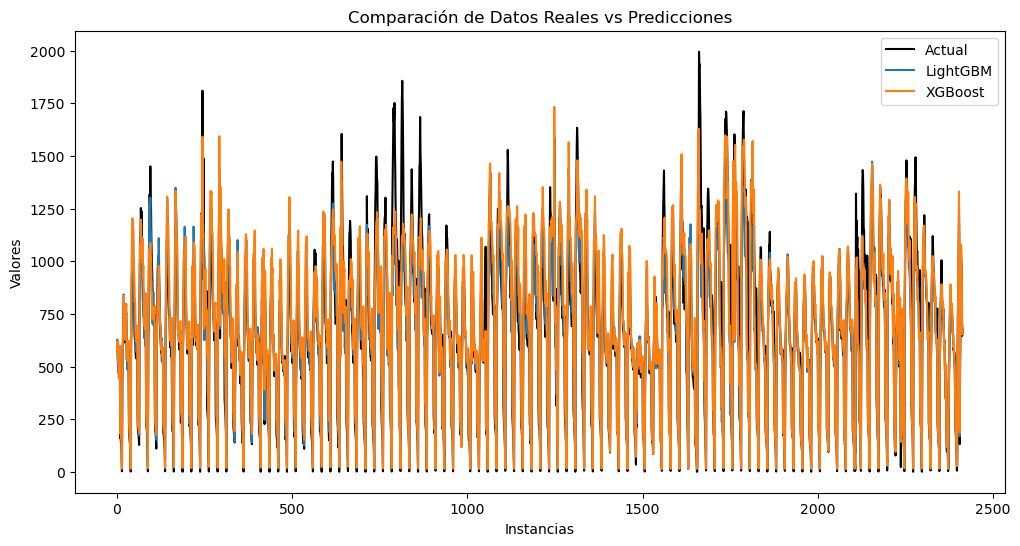

In [109]:
# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(predicciones_df_gb['Actual'].values, label='Actual', color='black')
for model_name in models.keys():
    plt.plot(predicciones_df_gb[model_name].values, label=model_name)
    
plt.title('Comparación de Datos Reales vs Predicciones')
plt.xlabel('Instancias')
plt.ylabel('Valores')
plt.legend()
plt.show()

## Prophet

Elegimos continuar con este modelo por la facilidad de uso (es altamente implementable por equipos no expertos). Además, permite un buen manejo de datos faltantes y valores atípicos., incorpora los efectos estacionales fuertes y tendencias históricas. Es flexible en cuanto al ajuste de parámetros y se adapta a diferentes tipos de datos.

Generamos los conjuntos de entrenamiento y de testeo utilizando tran_test_split
Revisamos que los conjutnos hayan quedado con el orden cronológico correcto


In [110]:
#Dividimos el dataframe en train y test
#Shuffle Falso para no perder el orden por "FECHA" en el que tenemos ordenado nuestro dataset para aplicar la serie teporal.
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

# Verificamos que los datos estén ordenados correctamente
print('Primeros datos del set de entrenamiento:\n')
print(df_train[['INICIO_INTERVALO']].head(4))

print('Últimos datos del set de entrenamiento:\n')
print(df_train[['INICIO_INTERVALO']].tail(4))

print('Primeros datos del set de test:\n')
print(df_test[['INICIO_INTERVALO']].head(4))

print('Últimos datos del set de test:\n')
print(df_test[['INICIO_INTERVALO']].tail(4))

Primeros datos del set de entrenamiento:

                          INICIO_INTERVALO
INICIO_INTERVALO                          
2022-01-03 08:30 2022-01-03 08:30:00+00:00
2022-01-03 09:00 2022-01-03 09:00:00+00:00
2022-01-03 09:30 2022-01-03 09:30:00+00:00
2022-01-03 10:00 2022-01-03 10:00:00+00:00
Últimos datos del set de entrenamiento:

                          INICIO_INTERVALO
INICIO_INTERVALO                          
2023-11-22 17:00 2023-11-22 17:00:00+00:00
2023-11-22 17:30 2023-11-22 17:30:00+00:00
2023-11-22 18:00 2023-11-22 18:00:00+00:00
2023-11-22 18:30 2023-11-22 18:30:00+00:00
Primeros datos del set de test:

                          INICIO_INTERVALO
INICIO_INTERVALO                          
2023-11-22 19:00 2023-11-22 19:00:00+00:00
2023-11-22 19:30 2023-11-22 19:30:00+00:00
2023-11-22 20:00 2023-11-22 20:00:00+00:00
2023-11-22 20:30 2023-11-22 20:30:00+00:00
Últimos datos del set de test:

                          INICIO_INTERVALO
INICIO_INTERVALO                   

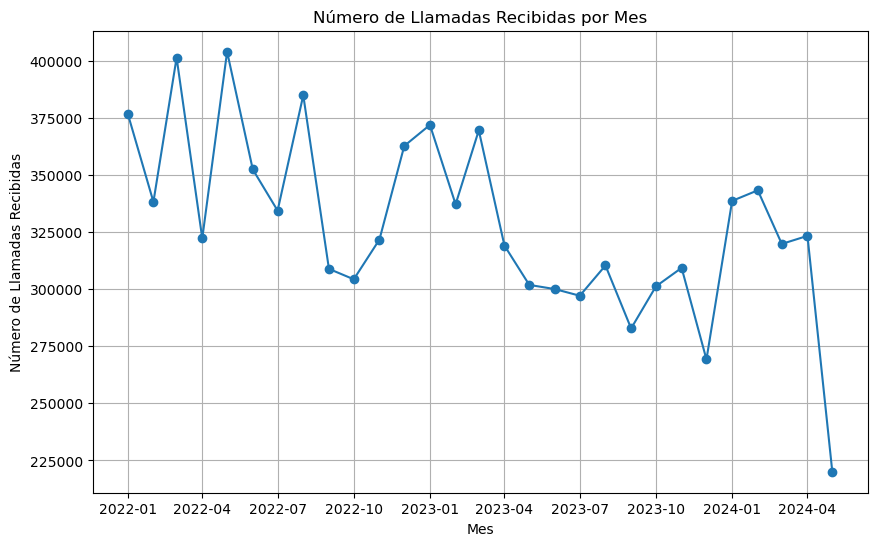

<Figure size 1000x600 with 0 Axes>

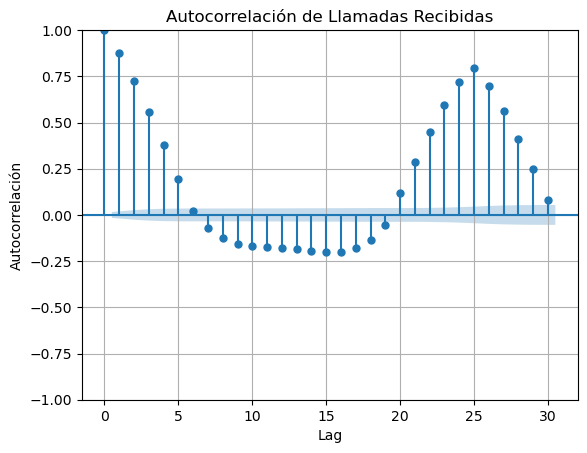

In [111]:
# Agrupar los datos por año y mes y sumar el número de llamadas recibidas en cada mes
llamadas_por_mes = df.groupby(df['INICIO_INTERVALO'].dt.to_period('M'))['Llamadas_recibidas'].sum()

# Convertir el índice a datetime para asegurar la correcta representación en el gráfico
llamadas_por_mes.index = llamadas_por_mes.index.to_timestamp()

# Crear un gráfico de la serie de tiempo de llamadas recibidas por mes
plt.figure(figsize=(10, 6))
plt.plot(llamadas_por_mes.index, llamadas_por_mes.values, marker='o', linestyle='-')
plt.title('Número de Llamadas Recibidas por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Llamadas Recibidas')
plt.grid(True)
plt.show()

# Calcular y trazar la autocorrelación de las llamadas recibidas
plt.figure(figsize=(10, 6))
plot_acf(df['Llamadas_recibidas'], lags=30)
plt.title('Autocorrelación de Llamadas Recibidas')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.grid(True)
plt.show()

## Aplicación FB Prophet

Nos aseguramos de que el campo 'INICIO_INTERVALO' sea de tipo datetime y eliminamos la zona horaria. Para utilizar en el modelo debe tener este formato.

In [112]:
df.columns

Index(['RN', 'FECHA', 'INICIO_INTERVALO', 'Llamadas_recibidas',
       'Llamadas_atendidas', 'PERIODO_CIERRE', 'PERIODO_PAGO',
       'PERIODO_RESTO_MES', 'FECHA_ENVIO_RDC', 'FECHA.1', 'ANIO', 'MES',
       'TRIMES', 'DIASEM', 'DIAMES', 'DIAAANIO', 'SEMANA', 'DIA_HABIL',
       'timeIndex', 'HORARIOS', 'Turnos'],
      dtype='object')

In [113]:
df['INICIO_INTERVALO'] = pd.to_datetime(df['INICIO_INTERVALO']).dt.tz_localize(None)
df_train['INICIO_INTERVALO'] = pd.to_datetime(df_train['INICIO_INTERVALO']).dt.tz_localize(None)
df_test['INICIO_INTERVALO'] = pd.to_datetime(df_test['INICIO_INTERVALO']).dt.tz_localize(None)

Debemos crear un "nuevo dataset" nombrando al target con "y" y al índice con "ds" para poder trabajar con el modelo Prophet

In [114]:
# Renombrar columnas a los nombres requeridos por Prophet
df = df.rename(columns={'INICIO_INTERVALO': 'ds', 'Llamadas_recibidas': 'y'})
df_train = df_train.rename(columns={'INICIO_INTERVALO': 'ds', 'Llamadas_recibidas': 'y'})
df_test = df_test.rename(columns={'INICIO_INTERVALO': 'ds', 'Llamadas_recibidas': 'y'})


# Inicializar el modelo Prophet
model = Prophet()


# Entrenar el modelo con los datos de entrenamiento
model.fit(df_train)


# Hacer predicciones para 2024
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

09:26:41 - cmdstanpy - INFO - Chain [1] start processing
09:26:46 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

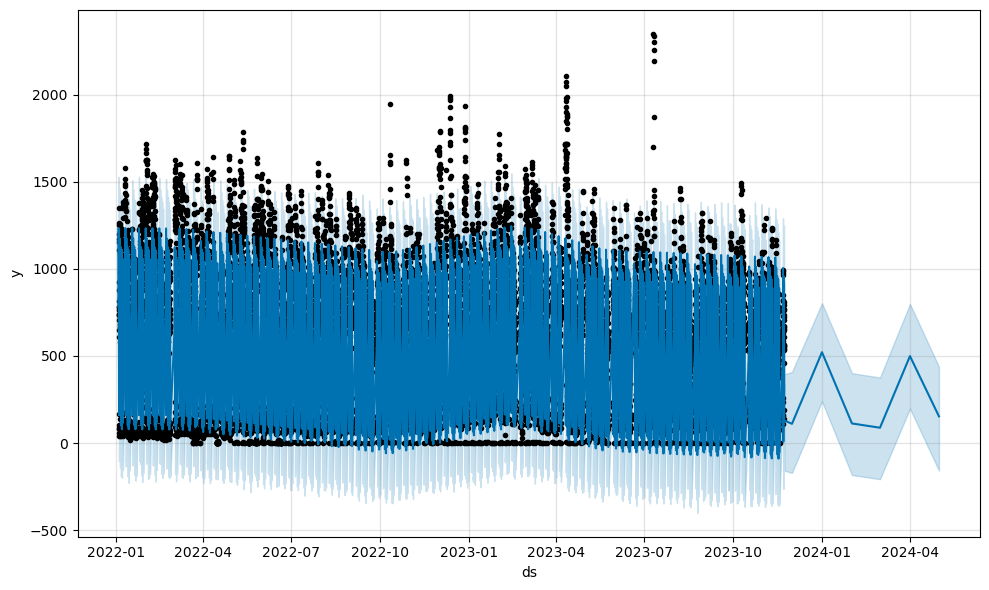

In [115]:

plt.figure(figsize=(10, 6))

fig = model.plot(forecast)

In [116]:
# Filtrar las predicciones para el período de prueba
forecast_test = forecast[forecast['ds'] >= '2024-01-01']

# Unir las predicciones con los datos reales de prueba
test_with_pred = pd.merge(df_test, forecast_test[['ds', 'yhat']], on='ds', how='inner')


mse, mae, r2, rmse = errores(test_with_pred['y'],test_with_pred['yhat'])
# Calcular el MAE
print("Mean Absolute Error (MAE):", mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R^2:', r2)

Mean Absolute Error (MAE): 106.45
Mean Squared Error (MSE): 11648.3
Root Mean Squared Error (RMSE): 107.93
R^2: -384.07


In [117]:
# Grid
param_grid = {  
                'changepoint_prior_scale': [0.005, 0.01, 0.05],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1],
                'holidays_prior_scale':[0.1, 1],
                'seasonality_mode': ['multiplicative', 'additive']}#,
                #'growth': ['linear', 'logistic']}
               #'yearly_seasonality': [5, 10, 20]
        
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
     'seasonality_mode': ['multiplicative', 'additive']
}
m = Prophet()
grid = ParameterGrid(param_grid)
cnt = 0
for p in grid:
    cnt = cnt+1
print('Total Possible Models',cnt)

Total Possible Models 24


In [118]:
# Definir variables
fcst_size = 31*48
freq = "30T"
strt = start_day = '2022-01-03'
end = end_day = '2022-01-31'
df_train = df_train  # Asegúrate de definir df_train y df_test
df_test = df_test
grid = grid  # Asegúrate de definir el grid con los parámetros a probar

# DataFrame para almacenar los resultados
model_parameters = pd.DataFrame(columns=['MSE', 'MAE', 'Parameters'])

# Loop para entrenar modelos con diferentes parámetros
for p in grid:
    test = pd.DataFrame()
    random.seed(0)
    
    train_model = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        weekly_seasonality=True,
        daily_seasonality=True,
        yearly_seasonality=False,
        interval_width=0.95
    ).add_seasonality(name='monthly', period=20 * 30, fourier_order=5)
    
    # Fit the model
    train_model.fit(df_train.reset_index())
    
    # Create future dataframe
    train_forecast = train_model.make_future_dataframe(periods=fcst_size, freq=freq, include_history=False)
    train_forecast = train_forecast[train_forecast['ds'].isin(df_test['ds'])]
    
    # Predict
    train_forecast = train_model.predict(train_forecast)
    
    # Obtain predictions for the test set
    test = train_forecast[['ds', 'yhat']]
    
    # Get actual values
    actual = df_test[df_test['ds'].isin(test['ds'])]
    
    # Calculate MSE and MAE
    mse, mae, r2, rmse = errores(actual['y'].values, test['yhat'].values)

    #MSE = round(mean_squared_error(actual['y'].values, test['yhat'].values), 2)
    #MAE = round(mean_absolute_error(actual['y'].values, test['yhat'].values), 2)
    #RMSE = round(np.sqrt(mean_squared_error(test_with_pred['y'], test_with_pred['yhat'])), 2)
    #r2 = round(r2_score(test_with_pred['y'], test_with_pred['yhat']), 2)
    
    
    # Append to DataFrame
    #current_results = pd.DataFrame({'MSE': [MSE], 'MAE': [MAE], 'RMSE': [RMSE],'R2':[r2], 'Parameters': [p]})
    current_results = pd.DataFrame({'MSE': [mse], 'MAE': [mae], 'RMSE': [rmse],'R2':[r2], 'Parameters': [p]})
    model_parameters = pd.concat([model_parameters, current_results], ignore_index=True)

# Encontrar el valor mínimo de MAE
min_mae = model_parameters['MAE'].min()

# Filtrar el DataFrame para obtener la fila con el mínimo valor de MAE
best_mae_params = model_parameters[model_parameters['MAE'] == min_mae]


09:26:51 - cmdstanpy - INFO - Chain [1] start processing
09:26:52 - cmdstanpy - INFO - Chain [1] done processing
09:26:53 - cmdstanpy - INFO - Chain [1] start processing
09:26:54 - cmdstanpy - INFO - Chain [1] done processing
09:26:55 - cmdstanpy - INFO - Chain [1] start processing
09:26:56 - cmdstanpy - INFO - Chain [1] done processing
09:26:57 - cmdstanpy - INFO - Chain [1] start processing
09:26:59 - cmdstanpy - INFO - Chain [1] done processing
09:27:00 - cmdstanpy - INFO - Chain [1] start processing
09:27:01 - cmdstanpy - INFO - Chain [1] done processing
09:27:02 - cmdstanpy - INFO - Chain [1] start processing
09:27:03 - cmdstanpy - INFO - Chain [1] done processing
09:27:05 - cmdstanpy - INFO - Chain [1] start processing
09:27:07 - cmdstanpy - INFO - Chain [1] done processing
09:27:08 - cmdstanpy - INFO - Chain [1] start processing
09:27:10 - cmdstanpy - INFO - Chain [1] done processing
09:27:11 - cmdstanpy - INFO - Chain [1] start processing
09:27:13 - cmdstanpy - INFO - Chain [1]

In [119]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

MSE     MAE                                         Parameters  \
0  20408.89  100.90  {'changepoint_prior_scale': 0.01, 'seasonality...   
1  20408.89  100.90  {'changepoint_prior_scale': 0.01, 'seasonality...   
2  20408.89  100.90  {'changepoint_prior_scale': 0.01, 'seasonality...   
3  20448.95  101.53  {'changepoint_prior_scale': 0.1, 'seasonality_...   
4  20448.95  101.53  {'changepoint_prior_scale': 0.1, 'seasonality_...   

     RMSE    R2  
0  142.86  0.76  
1  142.86  0.76  
2  142.86  0.76  
3  143.00  0.76  
4  143.00  0.76

In [120]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.01,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.01}

Conclusiones:
Llegamos a un Error Absoluto Medio (MAE) mínimo de 102.21, con los parámetros indicados arriba:
- changepoint_prior_scale = 0.1 es el parámetro de ajuste la sensibilidad de detección automática de puntos de cambio, es decir, prophet busca las instancias en los datos donde las trayectorias cambian de manera abrupta. Este valor significa que la tendencia es muy rígida, por lo que el modelo no permitirá que la tendencia se ajuste demasiado a los cambios repentinos en los datos.
- Seasonality_mode = Mltiplicative, quiere decir que en una serie temporal donde los patrones estacionales son más pronunciados a niveles más altos de la serie y menos pronunciados a niveles más bajos.
- Seasonality prior scale = 0.01 este parámetro controla la flexibilidad del componente de estacionalidad en el modelo, este valor pequeño  significa que el componente de estacionalidad será más rígido y menos capaz de ajustarse a fluctuaciones rápidas en los datos estacionales

## Ensambles

El ensamble, a diferencia del boosting, permite usar diferentes estrategias a la hora de combinar modelos.
Elegimos construir un modelo ensamblando LinReg y LightGBM, dos modelos que por separado habían dado buenos resultados y que, por la distancia entre ambos, resultan una combinación más que interesante para cancelar errores y complementar ventajas y limitaciones de ambos.

In [121]:
# Ensamble de Modelos linear y lightgbm que ya entrene previamente
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(X))
        return np.mean(predictions, axis=0)
    
# Crear el modelo de ensamble
ensemble_model = EnsembleModel([model_lin, trained_models['LightGBM']])
ensemble_model.models

# Hacer predicciones con el modelo de ensamble
y_pred_ensemble = ensemble_model.predict(X_test_fe[top_features])

mse, mae, r2, rmse = errores(y_test_fe, y_pred_ensemble)
print("MAE del modelo de ensamble:", mae)
print("MSE del modelo de ensamble:", mse)
print("RMSE del modelo de ensamble:", rmse)
print("R2 del modelo de ensamble:", r2)

MAE del modelo de ensamble: 76.07
MSE del modelo de ensamble: 15687.23
RMSE del modelo de ensamble: 125.25
R2 del modelo de ensamble: 0.88


Como podemos observar, las métricas obtenidas mejoran las que obtuvimos en el uso de los modelos por separado, y esto se puede atribuir justamente a las ventajas de ralizar el ensamble, que en pocas palabras se resume en "combinar lo mejor de dos mundos muy diferentes".

Las ventajas puntuales de combinar estos dos modelos incluyen pero no se limitan a:
- Captura de patrones simples y lineales (LinReg) y complejos y no lineales (LightGBM)
- Reducción de sesgo y varianza, al balancearse entre ambos (LinReg con tendencia a ser más sesgado y LightGBM con tendencia a mayor sobreajuste)
- Robustez, porque ensamblamos modelos con supuestos y requisitos totalmente diferentes.
- Interpretabilidad: Es mucho mayor para LinReg, que es más intuitivo pero no toma la cantidad de variables exógenas con las que contamos a la hora de realizar predicciones más precisas.


## Conclusiones Generales del Trabajo

A través del entrenamiento de dos modelos distantes (LinReg y LightGBM) en un ensamble, obtuvimos un modelo robusto, escalable y fiable para realizar predicciones de la cantidad de llamadas a recibir por el Contact Center en un mes determinado, tomando en cuenta las variables que pueden influir y que detallamos en la etapa inicial del análisis exploratorio. A partir del pasaje a producción y la utilización de este modelo, la empresa podrá determinar cuántas personas son necesarias para mantener en cada período de 30' una carga de trabajoa adecuada así como una calidad en la atención sobresaliente, con una inversión bien justificada.